# Multivariate Analysis

In [1]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\PG\df_nadal_clean.csv',sep=',')

In [3]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [13]:
X, y = df[['CC_FL','CC_BL','AT_Y','CC_BR','CC_FR',
'AU_395_FR','AU_355_FL','AT_X','AT_Z']], df[['L/V_BR']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

## Distribuição dados Treino x Teste para essa distribuição

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


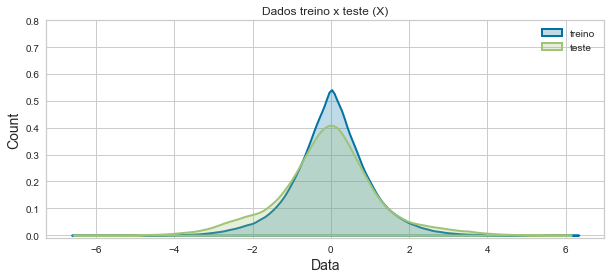

In [6]:
plt.figure(figsize=(10,4))
sns.distplot(X_train_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(X_test_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (X)")
plt.ylim([-0.01,0.8])
plt.legend(loc='upper right')

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


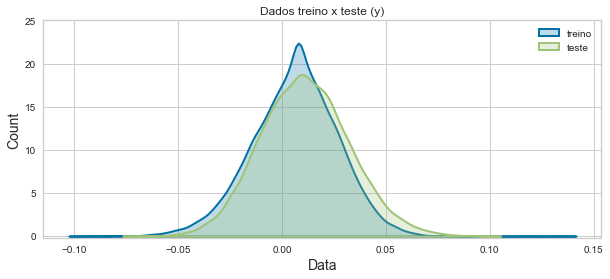

In [7]:
plt.figure(figsize=(10,4))
sns.distplot(y_train, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (y)")
plt.ylim([-0.2,25])
plt.legend(loc='upper right')

A distribuição parece ser representativa, podemos seguir em frente

In [5]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=9):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=9, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


In [6]:
study_rf = joblib.load("study_RandomForest.pkl")
study_ab = joblib.load("study_AdaBost.pkl")
study_en = joblib.load("study_ElasticNet.pkl")
study_xgb = joblib.load("study_XGBoost.pkl")


All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=32, max_features=6, min_samples_leaf=6,
                      min_samples_split=4, n_estimators=330, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\1229660262.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 50%|█████     | 3/6 [06:37<07:45, 155.13s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 4/6 [06:53<03:26, 103.26s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\1229660262.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 83%|████████▎ | 5/6 [07:00<01:09, 69.77s/it] c:\Users\DELL\.conda\envs

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


Obtaining feature importance - 100%
CPU times: total: 19min 59s
Wall time: 7min 1s


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

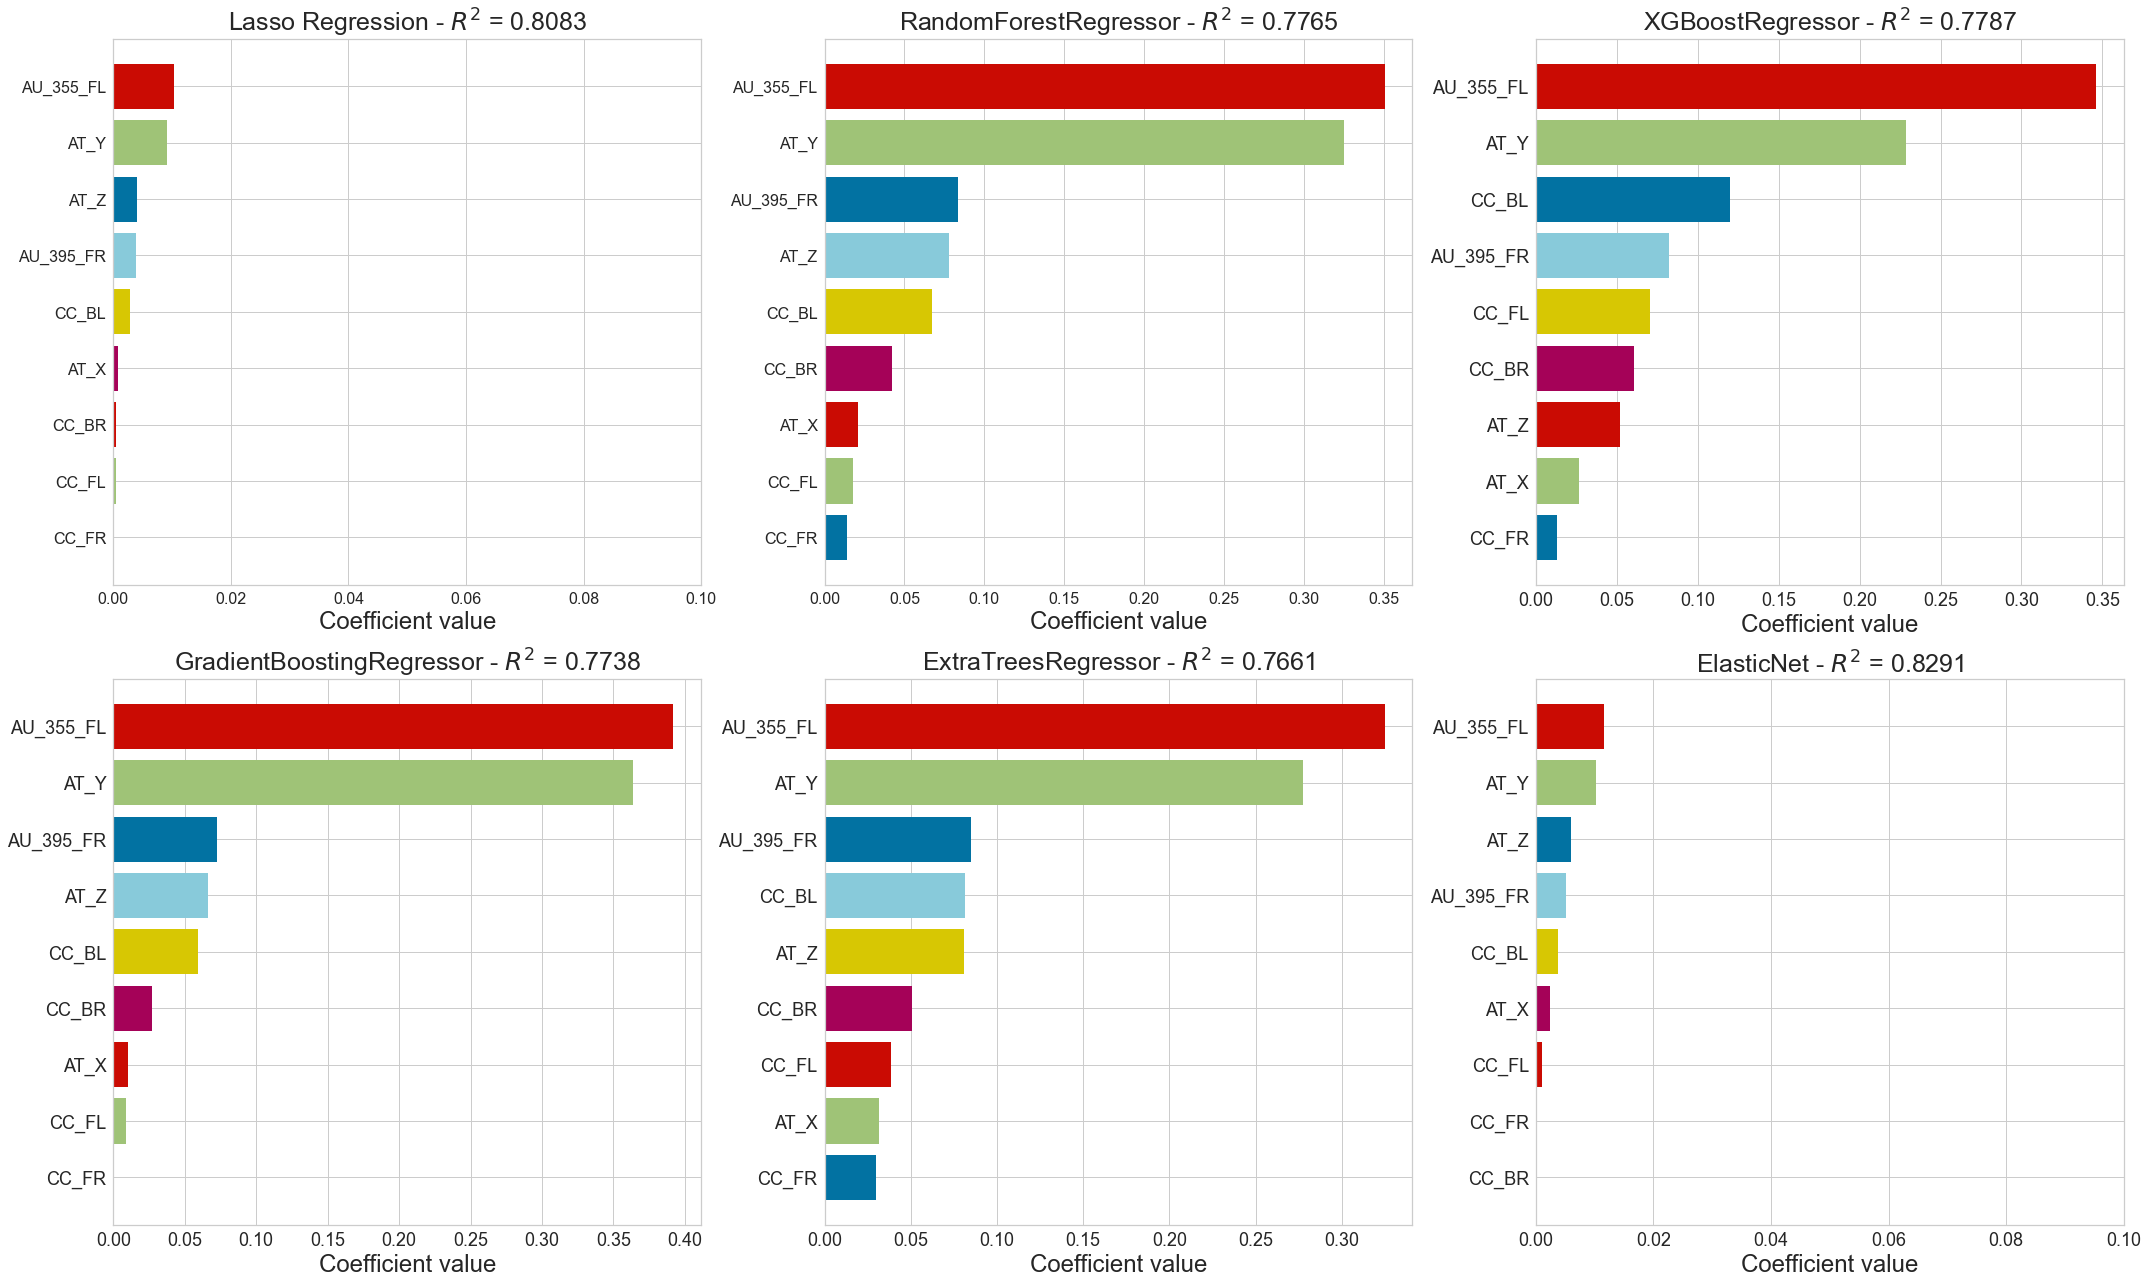

In [14]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [ ]:
#X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
#'AU_395_FR','AU_395_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_FR']]
#X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### Random Forest - FR

In [15]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-04 12:55:00,748] A new study created in memory with name: no-name-2529fb40-1b7e-4e0b-9192-82c348aaece4


In [16]:
study.optimize(objective, n_trials=20,show_progress_bar=True)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 12:56:00,006] Trial 0 finished with value: 0.7760960656179117 and parameters: {'n_estimators': 375, 'max_depth': 36, 'min_samples_leaf': 5, 'min_samples_split': 11, 'max_features': 5}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 12:58:01,894] Trial 1 finished with value: 0.7736266075979772 and parameters: {'n_estimators': 750, 'max_depth': 42, 'min_samples_leaf': 11, 'min_samples_split': 4, 'max_features': 8}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 12:58:46,442] Trial 2 finished with value: 0.7713035570598825 and parameters: {'n_estimators': 400, 'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 15, 'max_features': 7}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:00:29,172] Trial 3 finished with value: 0.7759973274070853 and parameters: {'n_estimators': 975, 'max_depth': 24, 'min_samples_leaf': 5, 'min_samples_split': 13, 'max_features': 7}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:00:45,734] Trial 4 finished with value: 0.7246382300142333 and parameters: {'n_estimators': 500, 'max_depth': 24, 'min_samples_leaf': 20, 'min_samples_split': 12, 'max_features': 2}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:01:31,363] Trial 5 finished with value: 0.7745488097059952 and parameters: {'n_estimators': 450, 'max_depth': 24, 'min_samples_leaf': 6, 'min_samples_split': 19, 'max_features': 7}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:01:52,313] Trial 6 finished with value: 0.7287216651676253 and parameters: {'n_estimators': 625, 'max_depth': 24, 'min_samples_leaf': 18, 'min_samples_split': 10, 'max_features': 2}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:02:15,610] Trial 7 finished with value: 0.772571261432115 and parameters: {'n_estimators': 225, 'max_depth': 36, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 7}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:02:39,830] Trial 8 finished with value: 0.5424938031001969 and parameters: {'n_estimators': 825, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5, 'max_features': 5}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:02:59,440] Trial 9 finished with value: 0.7705201173454144 and parameters: {'n_estimators': 275, 'max_depth': 22, 'min_samples_leaf': 13, 'min_samples_split': 15, 'max_features': 5}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:03:39,623] Trial 10 finished with value: 0.767419011657568 and parameters: {'n_estimators': 600, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 20, 'max_features': 4}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:04:58,551] Trial 11 finished with value: 0.7711727241138071 and parameters: {'n_estimators': 975, 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 10, 'max_features': 6}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:05:51,394] Trial 12 finished with value: 0.7640414067753045 and parameters: {'n_estimators': 1000, 'max_depth': 36, 'min_samples_leaf': 8, 'min_samples_split': 14, 'max_features': 3}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:06:18,063] Trial 13 finished with value: 0.7739732108765199 and parameters: {'n_estimators': 350, 'max_depth': 34, 'min_samples_leaf': 8, 'min_samples_split': 8, 'max_features': 5}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:06:57,449] Trial 14 finished with value: 0.7612024495875587 and parameters: {'n_estimators': 775, 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 17, 'max_features': 3}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:07:36,004] Trial 15 finished with value: 0.7724408613817257 and parameters: {'n_estimators': 600, 'max_depth': 32, 'min_samples_leaf': 8, 'min_samples_split': 2, 'max_features': 4}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:08:58,860] Trial 16 finished with value: 0.7751159212398112 and parameters: {'n_estimators': 875, 'max_depth': 44, 'min_samples_leaf': 4, 'min_samples_split': 12, 'max_features': 6}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:09:46,685] Trial 17 finished with value: 0.7732003077708067 and parameters: {'n_estimators': 675, 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 8, 'max_features': 5}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:10:50,497] Trial 18 finished with value: 0.7755552611957673 and parameters: {'n_estimators': 525, 'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 13, 'max_features': 8}. Best is trial 0 with value: 0.7760960656179117.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:11:24,423] Trial 19 finished with value: 0.7746794465360193 and parameters: {'n_estimators': 325, 'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 17, 'max_features': 7}. Best is trial 0 with value: 0.7760960656179117.
Accuracy: 0.7760960656179117
Best hyperparameters: {'n_estimators': 375, 'max_depth': 36, 'min_samples_leaf': 5, 'min_samples_split': 11, 'max_features': 5}


In [17]:
joblib.dump(study, "study_RandomForest_B.pkl")

['study_RandomForest_B.pkl']

In [18]:
study.best_trial

FrozenTrial(number=0, values=[0.7760960656179117], datetime_start=datetime.datetime(2022, 12, 4, 12, 55, 7, 247055), datetime_complete=datetime.datetime(2022, 12, 4, 12, 56, 0, 5021), params={'n_estimators': 375, 'max_depth': 36, 'min_samples_leaf': 5, 'min_samples_split': 11, 'max_features': 5}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=25), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

In [20]:
optuna.visualization.plot_optimization_history(study)

In [21]:
optuna.visualization.plot_slice(study)

### Extra-Trees Regressor

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):
    
        
    param = {
        'n_estimators': trial.suggest_int('n_estimators',200,800,25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,10,1),
        'random_state': 2020,
        #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',1,1000,25),
       
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf',0.0,0.2,step=0.01),
    
    }
    
    model = ExtraTreesRegressor(**param)    
  
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ext = optuna.create_study(direction='maximize')

[I 2022-12-04 13:11:25,241] A new study created in memory with name: no-name-94081648-d9e3-4cab-b88a-2bdb1b3e75da


In [20]:
study_ext.optimize(objective, n_trials=100,show_progress_bar=True)

trial_ext = study_ext.best_trial

print('Accuracy: {}'.format(trial_ext.value))
print("Best hyperparameters: {}".format(trial_ext.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:11:50,433] Trial 0 finished with value: 0.7511057363829676 and parameters: {'n_estimators': 400, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 0 with value: 0.7511057363829676.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:11:58,203] Trial 1 finished with value: 0.2569719831112942 and parameters: {'n_estimators': 725, 'max_depth': 14, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.13}. Best is trial 0 with value: 0.7511057363829676.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:12:01,946] Trial 2 finished with value: 0.24066564316052397 and parameters: {'n_estimators': 425, 'max_depth': 10, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.14}. Best is trial 0 with value: 0.7511057363829676.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:12:11,310] Trial 3 finished with value: 0.46122612349723335 and parameters: {'n_estimators': 650, 'max_depth': 4, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 0 with value: 0.7511057363829676.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:12:30,695] Trial 4 finished with value: 0.6967884807129874 and parameters: {'n_estimators': 425, 'max_depth': 10, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.0}. Best is trial 0 with value: 0.7511057363829676.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:15,489] Trial 5 finished with value: 0.7662966421638647 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:17,819] Trial 6 finished with value: 0.17269805159990925 and parameters: {'n_estimators': 375, 'max_depth': 6, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.18}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:23,694] Trial 7 finished with value: 0.37090236979949176 and parameters: {'n_estimators': 575, 'max_depth': 14, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.08}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:27,628] Trial 8 finished with value: 0.28043281048848645 and parameters: {'n_estimators': 575, 'max_depth': 2, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.04}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:31,228] Trial 9 finished with value: 0.18613346596585645 and parameters: {'n_estimators': 550, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.17}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:33,777] Trial 10 finished with value: 0.41360710816343205 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.07}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:46,192] Trial 11 finished with value: 0.5052272637714854 and parameters: {'n_estimators': 775, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.04}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:13:52,264] Trial 12 finished with value: 0.5426464467048482 and parameters: {'n_estimators': 325, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.03}. Best is trial 5 with value: 0.7662966421638647.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:10,131] Trial 13 finished with value: 0.7663367762364409 and parameters: {'n_estimators': 275, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:12,732] Trial 14 finished with value: 0.44581658194022344 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.06}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:15,709] Trial 15 finished with value: 0.32888903394830904 and parameters: {'n_estimators': 300, 'max_depth': 18, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.1}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:29,535] Trial 16 finished with value: 0.5802674841857436 and parameters: {'n_estimators': 650, 'max_depth': 20, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:33,382] Trial 17 finished with value: 0.13776088044644763 and parameters: {'n_estimators': 675, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.2}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:40,494] Trial 18 finished with value: 0.32536429927446975 and parameters: {'n_estimators': 800, 'max_depth': 8, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:50,494] Trial 19 finished with value: 0.5785693249952385 and parameters: {'n_estimators': 500, 'max_depth': 16, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:14:54,330] Trial 20 finished with value: 0.47302251089897407 and parameters: {'n_estimators': 275, 'max_depth': 12, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.05}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:15:18,329] Trial 21 finished with value: 0.7611379833956781 and parameters: {'n_estimators': 425, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:15:28,344] Trial 22 finished with value: 0.5785693249952385 and parameters: {'n_estimators': 500, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:15:44,246] Trial 23 finished with value: 0.7652948315175112 and parameters: {'n_estimators': 250, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:15:49,294] Trial 24 finished with value: 0.5861962278112329 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:15:53,009] Trial 25 finished with value: 0.37384253280160973 and parameters: {'n_estimators': 350, 'max_depth': 18, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.08}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:15:56,558] Trial 26 finished with value: 0.5063244299135434 and parameters: {'n_estimators': 225, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.04}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:16:04,019] Trial 27 finished with value: 0.6397179374678948 and parameters: {'n_estimators': 275, 'max_depth': 12, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:16:11,158] Trial 28 finished with value: 0.4625180812738019 and parameters: {'n_estimators': 475, 'max_depth': 20, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.05}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:16:30,055] Trial 29 finished with value: 0.7510099800191838 and parameters: {'n_estimators': 375, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:16:35,732] Trial 30 finished with value: 0.2748977203170734 and parameters: {'n_estimators': 725, 'max_depth': 16, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.12}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:17:04,761] Trial 31 finished with value: 0.7653645679531247 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:17:13,937] Trial 32 finished with value: 0.6361668810596974 and parameters: {'n_estimators': 325, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:17:26,184] Trial 33 finished with value: 0.5427574509936105 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.03}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:17:39,062] Trial 34 finished with value: 0.6361648454799673 and parameters: {'n_estimators': 475, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:17:53,697] Trial 35 finished with value: 0.7628052750675514 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:18:11,513] Trial 36 finished with value: 0.6366849256009736 and parameters: {'n_estimators': 725, 'max_depth': 12, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:18:19,017] Trial 37 finished with value: 0.5419842122514698 and parameters: {'n_estimators': 425, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.03}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:18:22,741] Trial 38 finished with value: 0.21451296240821183 and parameters: {'n_estimators': 550, 'max_depth': 14, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.15}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:18:38,268] Trial 39 finished with value: 0.6408219472066568 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:18:43,047] Trial 40 finished with value: 0.4310458373090139 and parameters: {'n_estimators': 400, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.06}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:18:57,452] Trial 41 finished with value: 0.7628052750675514 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:19:04,814] Trial 42 finished with value: 0.6374694334168312 and parameters: {'n_estimators': 300, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:19:09,154] Trial 43 finished with value: 0.5470715086432136 and parameters: {'n_estimators': 250, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.03}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:19:23,776] Trial 44 finished with value: 0.7660517593121977 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:19:27,932] Trial 45 finished with value: 0.5850975043503294 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:19:31,461] Trial 46 finished with value: 0.5063244299135434 and parameters: {'n_estimators': 225, 'max_depth': 20, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.04}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:19:39,719] Trial 47 finished with value: 0.6361668810596974 and parameters: {'n_estimators': 325, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:19:41,024] Trial 48 finished with value: 0.30120770301978295 and parameters: {'n_estimators': 200, 'max_depth': 2, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.03}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:20:25,382] Trial 49 finished with value: 0.7659233011444274 and parameters: {'n_estimators': 700, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:20:35,739] Trial 50 finished with value: 0.4660890505851669 and parameters: {'n_estimators': 725, 'max_depth': 20, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.05}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:21:25,630] Trial 51 finished with value: 0.7658738940472861 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:21:39,324] Trial 52 finished with value: 0.5812212651655734 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:21:49,235] Trial 53 finished with value: 0.4630843544291229 and parameters: {'n_estimators': 700, 'max_depth': 4, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:22:39,429] Trial 54 finished with value: 0.765782371260743 and parameters: {'n_estimators': 750, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:22:54,672] Trial 55 finished with value: 0.5813714026540895 and parameters: {'n_estimators': 750, 'max_depth': 20, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:23:36,476] Trial 56 finished with value: 0.765863513816905 and parameters: {'n_estimators': 650, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:23:41,934] Trial 57 finished with value: 0.27114971800263765 and parameters: {'n_estimators': 650, 'max_depth': 20, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.12}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:23:55,780] Trial 58 finished with value: 0.6354482833160304 and parameters: {'n_estimators': 550, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:24:06,579] Trial 59 finished with value: 0.5438004109991459 and parameters: {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.03}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:24:11,086] Trial 60 finished with value: 0.1722072465390011 and parameters: {'n_estimators': 700, 'max_depth': 20, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.18}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:25:00,977] Trial 61 finished with value: 0.7658048009063309 and parameters: {'n_estimators': 775, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:25:21,080] Trial 62 finished with value: 0.6365450098971461 and parameters: {'n_estimators': 800, 'max_depth': 20, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:26:04,281] Trial 63 finished with value: 0.7654245065083116 and parameters: {'n_estimators': 675, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:26:12,564] Trial 64 finished with value: 0.34634174678613106 and parameters: {'n_estimators': 775, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.09}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:26:25,751] Trial 65 finished with value: 0.5802674841857436 and parameters: {'n_estimators': 650, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:27:14,205] Trial 66 finished with value: 0.7640332670591976 and parameters: {'n_estimators': 775, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:27:29,954] Trial 67 finished with value: 0.6360110699336305 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:27:43,943] Trial 68 finished with value: 0.5815613802716488 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:28:03,206] Trial 69 finished with value: 0.6403268116961545 and parameters: {'n_estimators': 525, 'max_depth': 8, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:28:11,518] Trial 70 finished with value: 0.2158182664448759 and parameters: {'n_estimators': 750, 'max_depth': 10, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.15}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:29:07,086] Trial 71 finished with value: 0.765782371260743 and parameters: {'n_estimators': 750, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:29:50,503] Trial 72 finished with value: 0.7658261680958643 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:30:07,448] Trial 73 finished with value: 0.6359855163833192 and parameters: {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:30:25,014] Trial 74 finished with value: 0.6360110699336305 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:30:38,822] Trial 75 finished with value: 0.5812212651655734 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:31:16,763] Trial 76 finished with value: 0.7662477244683314 and parameters: {'n_estimators': 575, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:31:25,862] Trial 77 finished with value: 0.5019032516070931 and parameters: {'n_estimators': 575, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.04}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:31:30,258] Trial 78 finished with value: 0.13441466680319025 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.2}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:32:09,048] Trial 79 finished with value: 0.7631185515004515 and parameters: {'n_estimators': 575, 'max_depth': 16, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:32:26,828] Trial 80 finished with value: 0.6362544177383676 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 13 with value: 0.7663367762364409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:33:08,999] Trial 81 finished with value: 0.7664639877239408 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 81 with value: 0.7664639877239408.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:33:51,494] Trial 82 finished with value: 0.7664639877239408 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 81 with value: 0.7664639877239408.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:34:03,680] Trial 83 finished with value: 0.5793674564474964 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 81 with value: 0.7664639877239408.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:34:26,315] Trial 84 finished with value: 0.6358805903722269 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 81 with value: 0.7664639877239408.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:35:19,194] Trial 85 finished with value: 0.7664639877239408 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 81 with value: 0.7664639877239408.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:35:34,240] Trial 86 finished with value: 0.6359219120985053 and parameters: {'n_estimators': 575, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 81 with value: 0.7664639877239408.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:35:43,849] Trial 87 finished with value: 0.5424584768557541 and parameters: {'n_estimators': 550, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.03}. Best is trial 81 with value: 0.7664639877239408.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:36:35,043] Trial 88 finished with value: 0.7692159610616537 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:36:39,867] Trial 89 finished with value: 0.5860929682652082 and parameters: {'n_estimators': 225, 'max_depth': 14, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.02}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:37:25,578] Trial 90 finished with value: 0.7641731310840594 and parameters: {'n_estimators': 625, 'max_depth': 16, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:38:17,963] Trial 91 finished with value: 0.7676883628116636 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:39:12,186] Trial 92 finished with value: 0.7692159610616537 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:39:32,488] Trial 93 finished with value: 0.6362949819695334 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:40:19,491] Trial 94 finished with value: 0.7662635162003798 and parameters: {'n_estimators': 625, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:40:36,708] Trial 95 finished with value: 0.6359855163833192 and parameters: {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:41:15,083] Trial 96 finished with value: 0.767252725599755 and parameters: {'n_estimators': 525, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:41:27,941] Trial 97 finished with value: 0.5798304383791357 and parameters: {'n_estimators': 625, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.02}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:41:50,237] Trial 98 finished with value: 0.6362203202355117 and parameters: {'n_estimators': 675, 'max_depth': 16, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.01}. Best is trial 88 with value: 0.7692159610616537.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1788\283992923.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-04 13:42:31,064] Trial 99 finished with value: 0.7691438943287094 and parameters: {'n_estimators': 525, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 88 with value: 0.7692159610616537.
Accuracy: 0.7692159610616537
Best hyperparameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}


In [21]:
joblib.dump(study_ext, "study_ExtraTrees_B.pkl")

['study_ExtraTrees_B.pkl']

In [27]:
optuna.visualization.plot_optimization_history(study_ext)

In [32]:
optuna.visualization.plot_slice(study_ext)

### ElasticNet

In [22]:
from sklearn.linear_model import ElasticNet

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=10, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=1,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_en = optuna.create_study(direction='maximize')

[I 2022-12-04 13:42:31,324] A new study created in memory with name: no-name-c4412f5e-e556-4446-81e7-b35b92feccc6


In [23]:
study_en.optimize(objective, n_trials=1000,show_progress_bar=True)

trial_en = study_en.best_trial

print('Accuracy: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-12-04 13:42:31,452] Trial 0 finished with value: -0.10210968260306963 and parameters: {'alpha': 9.6702, 'l1_ratio': 0.84, 'selection': 'random'}. Best is trial 0 with value: -0.10210968260306963.
[I 2022-12-04 13:42:31,473] Trial 1 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.0917000000000003, 'l1_ratio': 0.61, 'selection': 'random'}. Best is trial 0 with value: -0.10210968260306963.
[I 2022-12-04 13:42:31,494] Trial 2 finished with value: -0.10210968260306963 and parameters: {'alpha': 9.934800000000001, 'l1_ratio': 0.74, 'selection': 'cyclic'}. Best is trial 0 with value: -0.10210968260306963.
[I 2022-12-04 13:42:31,516] Trial 3 finished with value: -0.10210968260306963 and parameters: {'alpha': 9.0635, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 0 with value: -0.10210968260306963.
[I 2022-12-04 13:42:31,535] Trial 4 finished with value: -0.10210968260306963 and parameters: {'alpha': 9.7319, 'l1_ratio': 0.29, 'selection': 'cyclic'}. Best is

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.080e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:48,059] Trial 369 finished with value: 0.796854608182067 and parameters: {'alpha': 0.1877, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 223 with value: 0.8288942304358615.
[I 2022-12-04 13:42:48,130] Trial 370 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.398, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 223 with value: 0.8288942304358615.
[I 2022-12-04 13:42:48,187] Trial 371 finished with value: 0.8254786537680691 and parameters: {'alpha': 0.005, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 223 with value: 0.8288942304358615.
[I 2022-12-04 13:42:48,250] Trial 372 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1883, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 223 with value: 0.8288942304358615.
[I 2022-12-04 13:42:48,318] Trial 373 finished with value: 0.5428295814807467 and parameters: {'alpha': 0.19519999999999998, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 223

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:49,294] Trial 378 finished with value: 0.8289803729171458 and parameters: {'alpha': 0.001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 378 with value: 0.8289803729171458.
[I 2022-12-04 13:42:49,353] Trial 379 finished with value: 0.048102378386949196 and parameters: {'alpha': 0.8526, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 378 with value: 0.8289803729171458.
[I 2022-12-04 13:42:49,417] Trial 380 finished with value: 0.4091862155320789 and parameters: {'alpha': 0.4742, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 378 with value: 0.8289803729171458.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:50,129] Trial 381 finished with value: 0.7711603912231928 and parameters: {'alpha': 0.3245, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 378 with value: 0.8289803729171458.
[I 2022-12-04 13:42:50,192] Trial 382 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1914, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 378 with value: 0.8289803729171458.
[I 2022-12-04 13:42:50,279] Trial 383 finished with value: 0.8260663374793616 and parameters: {'alpha': 0.007600000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 378 with value: 0.8289803729171458.
[I 2022-12-04 13:42:50,375] Trial 384 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3627, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 378 with value: 0.8289803729171458.
[I 2022-12-04 13:42:50,457] Trial 385 finished with value: 0.8283323532754173 and parameters: {'alpha': 0.0034, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:52,669] Trial 392 finished with value: 0.8290703509539555 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.081e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:53,887] Trial 393 finished with value: 0.7460884522862448 and parameters: {'alpha': 0.46640000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:53,954] Trial 394 finished with value: 0.14146773776963895 and parameters: {'alpha': 0.2067, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:54,750] Trial 395 finished with value: 0.7967018103438901 and parameters: {'alpha': 0.1885, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:54,815] Trial 396 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.7543, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:54,863] Trial 397 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3669, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:55,612] Trial 398 finished with value: 0.7958806019061724 and parameters: {'alpha': 0.1928, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:55,668] Trial 399 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5572, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:56,367] Trial 400 finished with value: 0.7975613242054483 and parameters: {'alpha': 0.184, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:56,426] Trial 401 finished with value: 0.8245736027885214 and parameters: {'alpha': 0.0081, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:56,479] Trial 402 finished with value: 0.8237083928632865 and parameters: {'alpha': 0.007600000000000001, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:56,545] Trial 403 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3778, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:56,601] Trial 404 finished with value: 0.5399307781859404 and parameters: {'alpha': 0.1966, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 39

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:57,630] Trial 410 finished with value: 0.7969501083490995 and parameters: {'alpha': 0.1872, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:57,692] Trial 411 finished with value: 0.8286238041423131 and parameters: {'alpha': 0.0013000000000000002, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:57,750] Trial 412 finished with value: 0.8282422263670417 and parameters: {'alpha': 0.0024, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:57,813] Trial 413 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3244, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:57,884] Trial 414 finished with value: 0.5564796402183656 and parameters: {'alpha': 0.1885, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.066e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:42:58,675] Trial 417 finished with value: 0.7470104277041163 and parameters: {'alpha': 0.461, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:58,729] Trial 418 finished with value: 0.8236006070711512 and parameters: {'alpha': 0.006600000000000001, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:58,783] Trial 419 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.184, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:58,831] Trial 420 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3696, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:42:58,905] Trial 421 finished with value: 0.5586851278141509 and parameters: {'alpha': 0.1874, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 3

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:00,003] Trial 426 finished with value: 0.7962243437485732 and parameters: {'alpha': 0.191, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:00,104] Trial 427 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.8685, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:00,157] Trial 428 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4711, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:00,233] Trial 429 finished with value: 0.3421219720690526 and parameters: {'alpha': 0.1947, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:00,305] Trial 430 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3289, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with val

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.524e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:01,176] Trial 433 finished with value: 0.7174210791065041 and parameters: {'alpha': 0.6417, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:01,220] Trial 434 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.402, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:01,284] Trial 435 finished with value: 0.8109565940796409 and parameters: {'alpha': 0.0163, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:01,332] Trial 436 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1926, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:01,414] Trial 437 finished with value: 0.8260867241026024 and parameters: {'alpha': 0.009899999999999999, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:02,300] Trial 439 finished with value: 0.8274081871942118 and parameters: {'alpha': 0.013900000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.523e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:03,073] Trial 440 finished with value: 0.7766299701852981 and parameters: {'alpha': 0.2948, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:03,143] Trial 441 finished with value: 0.8275999355328968 and parameters: {'alpha': 0.0058000000000000005, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.643e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:04,051] Trial 442 finished with value: 0.7705207217485407 and parameters: {'alpha': 0.328, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:04,123] Trial 443 finished with value: -0.10210968260306963 and parameters: {'alpha': 1.1222, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:04,178] Trial 444 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.3243000000000005, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:05,025] Trial 445 finished with value: 0.8287281243263901 and parameters: {'alpha': 0.0032, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.709e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:05,807] Trial 446 finished with value: 0.7041045991912569 and parameters: {'alpha': 0.7281, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:05,862] Trial 447 finished with value: 0.18724826856086563 and parameters: {'alpha': 0.1934, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.210e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:07,102] Trial 448 finished with value: 0.7381833125490769 and parameters: {'alpha': 0.5133, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:07,329] Trial 449 finished with value: 0.8255911114624925 and parameters: {'alpha': 0.0068000000000000005, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:07,411] Trial 450 finished with value: 0.24234826418033517 and parameters: {'alpha': 0.3296, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:07,474] Trial 451 finished with value: 0.2541293125743521 and parameters: {'alpha': 0.1734, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:08,408] Trial 452 finished with value: 0.828361121469449 and parameters: {'alpha': 0.006300000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.686e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:09,201] Trial 453 finished with value: 0.7682992866252885 and parameters: {'alpha': 0.3402, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:09,948] Trial 454 finished with value: 0.8288665798264638 and parameters: {'alpha': 0.002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.341e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:10,712] Trial 455 finished with value: 0.729836891872853 and parameters: {'alpha': 0.5640000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:11,711] Trial 456 finished with value: 0.7950023385941267 and parameters: {'alpha': 0.1974, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:11,771] Trial 457 finished with value: 0.5332452337273572 and parameters: {'alpha': 0.1998, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:11,837] Trial 458 finished with value: 0.13663063509777484 and parameters: {'alpha': 0.3963, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:12,578] Trial 459 finished with value: 0.7997956116911573 and parameters: {'alpha': 0.1723, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:12,665] Trial 460 finished with value: 0.8283602403121051 and parameters: {'alpha': 0.0033, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:12,721] Trial 461 finished with value: 0.1571359614104505 and parameters: {'alpha': 0.3834, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:12,779] Trial 462 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6512, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:13,547] Trial 463 finished with value: 0.7954987107759206 and parameters: {'alpha': 0.1948, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:13,611] Trial 464 finished with value: 0.8271868812868827 and parameters: {'alpha': 0.0044, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:13,662] Trial 465 finished with value: 0.20315677025532386 and parameters: {'alpha': 0.3544, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:13,738] Trial 466 finished with value: 0.8289014085443065 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:13,808] Trial 467 finished with value: 0.34101755740244377 and parameters: {'alpha': 0.195, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.236e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:14,558] Trial 468 finished with value: 0.7365873703363941 and parameters: {'alpha': 0.5229, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:14,609] Trial 469 finished with value: -0.07556702594330766 and parameters: {'alpha': 0.2136, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:14,670] Trial 470 finished with value: 0.1673037355269008 and parameters: {'alpha': 0.377, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:14,734] Trial 471 finished with value: 0.26002362414942914 and parameters: {'alpha': 0.1716, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:15,635] Trial 472 finished with value: 0.828409215568447 and parameters: {'alpha': 0.005900000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:15,703] Trial 473 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.786, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:15,772] Trial 474 finished with value: -0.011319281504003964 and parameters: {'alpha': 0.48960000000000004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:15,833] Trial 475 finished with value: 0.16051807435258592 and parameters: {'alpha': 0.2012, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:15,911] Trial 476 finished with value: -0.10210968260306963 and parameters: {'alpha': 1.4844000000000002, 'l1_ratio': 0.07, 'selection

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:16,691] Trial 477 finished with value: 0.8279562914410263 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.803e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:17,603] Trial 478 finished with value: 0.7620522917631989 and parameters: {'alpha': 0.3749, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:17,688] Trial 479 finished with value: 0.567601745940554 and parameters: {'alpha': 0.1829, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:18,427] Trial 480 finished with value: 0.7688625254466988 and parameters: {'alpha': 0.3371, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:18,498] Trial 481 finished with value: 0.8251924909074444 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:18,557] Trial 482 finished with value: 0.5691689948300476 and parameters: {'alpha': 0.18209999999999998, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:18,636] Trial 483 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5589000000000001, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:19,354] Trial 484 finished with value: 0.8286346865145826 and parameters: {'alpha': 0.004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:20,566] Trial 485 finished with value: 0.8285994164822262 and parameters: {'alpha': 0.004300000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.622e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:21,812] Trial 486 finished with value: 0.7716179403246992 and parameters: {'alpha': 0.322, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:22,643] Trial 487 finished with value: 0.7958424105379217 and parameters: {'alpha': 0.193, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:23,443] Trial 488 finished with value: 0.8289916718504814 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:23,510] Trial 489 finished with value: -0.10210968260306963 and parameters: {'alpha': 7.2951, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:23,570] Trial 490 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6235, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.722e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:24,436] Trial 491 finished with value: 0.7664158495345538 and parameters: {'alpha': 0.3506, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:24,509] Trial 492 finished with value: 0.8275078886103646 and parameters: {'alpha': 0.0028, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:24,563] Trial 493 finished with value: 0.01141001291275967 and parameters: {'alpha': 0.4752, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:24,632] Trial 494 finished with value: 0.13170751355713306 and parameters: {'alpha': 0.2095, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:24,713] Trial 495 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1865, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 392 with valu

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.190e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:25,610] Trial 497 finished with value: 0.7921606493843495 and parameters: {'alpha': 0.2123, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:26,182] Trial 498 finished with value: -0.10210968260306963 and parameters: {'alpha': 5.5539, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:26,278] Trial 499 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4933, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:27,005] Trial 500 finished with value: 0.8288206569069061 and parameters: {'alpha': 0.0024, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.750e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:27,777] Trial 501 finished with value: 0.7010303025178055 and parameters: {'alpha': 0.7485, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:28,547] Trial 502 finished with value: 0.7987072884997628 and parameters: {'alpha': 0.178, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:28,604] Trial 503 finished with value: 0.2330434338519728 and parameters: {'alpha': 0.3355, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:28,666] Trial 504 finished with value: 0.8265238043081472 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:28,730] Trial 505 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.9294, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:29,394] Trial 506 finished with value: 0.7962625392590134 and parameters: {'alpha': 0.1908, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:29,464] Trial 507 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4769, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:30,170] Trial 508 finished with value: 0.7951932381998288 and parameters: {'alpha': 0.1964, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:30,237] Trial 509 finished with value: 0.3384361557945291 and parameters: {'alpha': 0.19569999999999999, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:30,288] Trial 510 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.631, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:30,359] Trial 511 finished with value: 0.17000371004144665 and parameters: {'alpha': 0.3753, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:30,430] Trial 512 finished with value: 0.8202575659398617 and parameters: {'alpha': 0.0126, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 39

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:31,130] Trial 513 finished with value: 0.8025032580279053 and parameters: {'alpha': 0.1581, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:31,194] Trial 514 finished with value: 0.8265917650016388 and parameters: {'alpha': 0.0045000000000000005, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:31,255] Trial 515 finished with value: 0.19412381404470047 and parameters: {'alpha': 0.36010000000000003, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:32,000] Trial 516 finished with value: 0.8288436471450945 and parameters: {'alpha': 0.0022, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.649e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:32,760] Trial 517 finished with value: 0.7702469000272449 and parameters: {'alpha': 0.3295, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.318e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:33,504] Trial 518 finished with value: 0.7313365622116781 and parameters: {'alpha': 0.5548000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:33,576] Trial 519 finished with value: 0.5749975506647884 and parameters: {'alpha': 0.1791, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:33,632] Trial 520 finished with value: 0.8274649795367023 and parameters: {'alpha': 0.006200000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:34,339] Trial 521 finished with value: 0.795517804071735 and parameters: {'alpha': 0.1947, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:34,394] Trial 522 finished with value: -0.006533633551839779 and parameters: {'alpha': 0.3286, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.119e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:35,107] Trial 523 finished with value: 0.7438112181855854 and parameters: {'alpha': 0.4798, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:35,180] Trial 524 finished with value: -0.10210968260306963 and parameters: {'alpha': 1.9152, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:35,235] Trial 525 finished with value: 0.5608804888718288 and parameters: {'alpha': 0.1863, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:35,326] Trial 526 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1608, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.809e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:36,077] Trial 527 finished with value: 0.2304236326556648 and parameters: {'alpha': 7.9223, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:36,145] Trial 528 finished with value: 0.8225231021039319 and parameters: {'alpha': 0.0104, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:36,198] Trial 529 finished with value: 0.21059887487759876 and parameters: {'alpha': 0.3497, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:36,264] Trial 530 finished with value: -0.07473248203969685 and parameters: {'alpha': 0.53, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:36,333] Trial 531 finished with value: -0.04437049758430023 and parameters: {'alpha': 0.1729, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.655e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:37,038] Trial 532 finished with value: 0.70810649616774 and parameters: {'alpha': 0.7018, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:37,098] Trial 533 finished with value: 0.8270676264852995 and parameters: {'alpha': 0.004600000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:37,171] Trial 534 finished with value: 0.8285729576627934 and parameters: {'alpha': 0.002, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:37,225] Trial 535 finished with value: 0.21376388903977162 and parameters: {'alpha': 0.3477, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:37,935] Trial 536 finished with value: 0.7961288565956945 and parameters: {'alpha': 0.1915, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:38,002] Trial 537 finished with value: 0.8288773357438148 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:38,061] Trial 538 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.44220000000000004, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:38,127] Trial 539 finished with value: 0.21865616816590117 and parameters: {'alpha': 0.18409999999999999, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:38,192] Trial 540 finished with value: 0.21708589776719134 and parameters: {'alpha': 0.3456, 'l1_ratio': 0.02, 'selection': 'cyclic'}. B

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.059e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:38,902] Trial 541 finished with value: 0.797714128620763 and parameters: {'alpha': 0.1832, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:38,971] Trial 542 finished with value: 0.8280222685925136 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:39,031] Trial 543 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.786, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:39,105] Trial 544 finished with value: 0.82890896018668 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:39,172] Trial 545 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5198, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:39,903] Trial 546 finished with value: 0.7762778898085995 and parameters: {'alpha': 0.2967, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:39,963] Trial 547 finished with value: 0.5955181350894976 and parameters: {'alpha': 0.1682, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:40,027] Trial 548 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.34500000000000003, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:40,075] Trial 549 finished with value: -0.022530718963591267 and parameters: {'alpha': 0.1692, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:40,153] Trial 550 finished with value: 0.8279803323142063 and parameters: {'alpha': 0.004600000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.492e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:40,906] Trial 551 finished with value: 0.7196893226687426 and parameters: {'alpha': 0.6273, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:40,971] Trial 552 finished with value: 0.8272455594983971 and parameters: {'alpha': 0.004300000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:41,037] Trial 553 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3647, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:41,115] Trial 554 finished with value: 0.48847241177698253 and parameters: {'alpha': 0.2213, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.209e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:41,868] Trial 555 finished with value: 0.7382666375163073 and parameters: {'alpha': 0.5128, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:41,937] Trial 556 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1837, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:41,992] Trial 557 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.9919000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:42,056] Trial 558 finished with value: 0.8276921328654793 and parameters: {'alpha': 0.0035, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:42,762] Trial 559 finished with value: 0.828878024521414 and parameters: {'alpha': 0.0019000000000000002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:43,505] Trial 560 finished with value: 0.7575471465423034 and parameters: {'alpha': 0.4003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:44,417] Trial 561 finished with value: 0.7950596066981321 and parameters: {'alpha': 0.1971, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:44,481] Trial 562 finished with value: -0.10210968260306963 and parameters: {'alpha': 1.0044, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.715e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:45,219] Trial 563 finished with value: 0.7667773121529388 and parameters: {'alpha': 0.3486, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:45,283] Trial 564 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6602, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:45,979] Trial 565 finished with value: 0.8006734438967578 and parameters: {'alpha': 0.1677, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:46,047] Trial 566 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.5785000000000005, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:46,104] Trial 567 finished with value: 0.8276975931384338 and parameters: {'alpha': 0.0055000000000000005, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:46,181] Trial 568 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3414, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:46,892] Trial 569 finished with value: 0.8286111870708024 and parameters: {'alpha': 0.004200000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:47,650] Trial 570 finished with value: 0.7942770898335323 and parameters: {'alpha': 0.2012, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.180e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:48,428] Trial 571 finished with value: 0.7400546455295444 and parameters: {'alpha': 0.5021, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:48,494] Trial 572 finished with value: 0.5944157193824116 and parameters: {'alpha': 0.1688, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.372e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:49,209] Trial 573 finished with value: 0.3417395281366308 and parameters: {'alpha': 4.92, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:49,267] Trial 574 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:49,332] Trial 575 finished with value: 0.828245696609603 and parameters: {'alpha': 0.0037, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.167e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:50,072] Trial 576 finished with value: 0.7408765669293621 and parameters: {'alpha': 0.49720000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:50,126] Trial 577 finished with value: 0.15395552970583826 and parameters: {'alpha': 0.2031, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:50,182] Trial 578 finished with value: 0.8279189239506659 and parameters: {'alpha': 0.0048000000000000004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:50,246] Trial 579 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.2929, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.888e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:50,927] Trial 580 finished with value: 0.6902770950417842 and parameters: {'alpha': 0.8212, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:50,987] Trial 581 finished with value: 0.39993548775048715 and parameters: {'alpha': 0.1787, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:51,051] Trial 582 finished with value: 0.05019899919411008 and parameters: {'alpha': 0.4507, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:51,127] Trial 583 finished with value: 0.8278084473373679 and parameters: {'alpha': 0.0024, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:51,829] Trial 584 finished with value: 0.7737479043082856 and parameters: {'alpha': 0.3104, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:51,884] Trial 585 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6482, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:51,943] Trial 586 finished with value: 0.2286754278154851 and parameters: {'alpha': 0.1811, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:52,016] Trial 587 finished with value: 0.5711203941986447 and parameters: {'alpha': 0.1811, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:52,737] Trial 588 finished with value: 0.8285047541130515 and parameters: {'alpha': 0.0051, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.109e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:53,464] Trial 589 finished with value: 0.7444215306998483 and parameters: {'alpha': 0.4762, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:54,225] Trial 590 finished with value: 0.8284212053924995 and parameters: {'alpha': 0.0058000000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:54,943] Trial 591 finished with value: 0.7689716360528327 and parameters: {'alpha': 0.3365, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:55,014] Trial 592 finished with value: 0.24952998675889326 and parameters: {'alpha': 0.1748, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:55,071] Trial 593 finished with value: 0.18857365192519737 and parameters: {'alpha': 0.3636, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:55,154] Trial 594 finished with value: 0.8262894863110064 and parameters: {'alpha': 0.004200000000000001, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:55,214] Trial 595 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6069, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:55,925] Trial 596 finished with value: 0.8284212053924995 and parameters: {'alpha': 0.0058000000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:56,013] Trial 597 finished with value: 0.15603004012628818 and parameters: {'alpha': 0.20249999999999999, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:56,076] Trial 598 finished with value: 0.2048990612386722 and parameters: {'alpha': 0.3533, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:56,820] Trial 599 finished with value: 0.8003300065252922 and parameters: {'alpha': 0.16949999999999998, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:56,902] Trial 600 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5124, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:56,960] Trial 601 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1811, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:57,039] Trial 602 finished with value: 0.21740221046866026 and parameters: {'alpha': 0.3454, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:57,111] Trial 603 finished with value: 0.818855750392355 and parameters: {'alpha': 0.0098, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.695e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:57,794] Trial 604 finished with value: 0.26153469127864115 and parameters: {'alpha': 6.9023, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:57,856] Trial 605 finished with value: -0.10210968260306963 and parameters: {'alpha': 3.3902000000000005, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:57,923] Trial 606 finished with value: 0.8288773357438148 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:57,997] Trial 607 finished with value: -0.09284997119014737 and parameters: {'alpha': 0.181, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:58,070] Trial 608 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.7041000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. B

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.641e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:43:59,166] Trial 615 finished with value: 0.27571616411308486 and parameters: {'alpha': 6.4921, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:59,238] Trial 616 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3137, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:59,298] Trial 617 finished with value: 0.2798356939778506 and parameters: {'alpha': 0.1655, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:43:59,373] Trial 618 finished with value: 0.21692773685099198 and parameters: {'alpha': 0.3457, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.989e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:00,165] Trial 619 finished with value: 0.8005398953529681 and parameters: {'alpha': 0.1684, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:00,226] Trial 620 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.8370000000000001, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:00,290] Trial 621 finished with value: 0.8235442337011576 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:00,363] Trial 622 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5618, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.644e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:01,013] Trial 623 finished with value: 0.770484200992037 and parameters: {'alpha': 0.3282, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:01,090] Trial 624 finished with value: 0.8213771655535833 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:01,163] Trial 625 finished with value: 0.8279803323142063 and parameters: {'alpha': 0.004600000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:01,237] Trial 626 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1928, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.168e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:02,110] Trial 627 finished with value: 0.7408093975786743 and parameters: {'alpha': 0.4976, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:02,180] Trial 628 finished with value: 0.8255537988350037 and parameters: {'alpha': 0.0085, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:02,235] Trial 629 finished with value: 0.2036319711284731 and parameters: {'alpha': 0.3541, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:02,922] Trial 630 finished with value: 0.8288551206927559 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:02,984] Trial 631 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.2095, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:03,061] Trial 632 finished with value: 0.8286362072813596 and parameters: {'alpha': 0.0015, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:03,129] Trial 633 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6439, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:03,201] Trial 634 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.332, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with val

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:04,254] Trial 640 finished with value: 0.8287629307950333 and parameters: {'alpha': 0.0029, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:04,327] Trial 641 finished with value: 0.5078278068982587 and parameters: {'alpha': 0.2119, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:05,040] Trial 642 finished with value: 0.7959951787432222 and parameters: {'alpha': 0.1922, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.993e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:05,783] Trial 643 finished with value: 0.7513286309747799 and parameters: {'alpha': 0.4359, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:05,845] Trial 644 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6964, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:05,917] Trial 645 finished with value: 0.8275294369345738 and parameters: {'alpha': 0.0038, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.067e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:06,647] Trial 646 finished with value: 0.5704115972450569 and parameters: {'alpha': 1.7842, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:06,713] Trial 647 finished with value: 0.8287424510896718 and parameters: {'alpha': 0.0018000000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:06,769] Trial 648 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3425, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:06,833] Trial 649 finished with value: 0.14111986783533914 and parameters: {'alpha': 0.2068, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:06,913] Trial 650 finished with value: 0.8279778728441862 and parameters: {'alpha': 0.0036, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:07,997] Trial 657 finished with value: 0.828900870495603 and parameters: {'alpha': 0.0017000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.032e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:08,790] Trial 658 finished with value: 0.7489993655280939 and parameters: {'alpha': 0.4494, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:09,540] Trial 659 finished with value: 0.7963771278743812 and parameters: {'alpha': 0.1902, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.685e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:10,238] Trial 660 finished with value: 0.7683355993357656 and parameters: {'alpha': 0.34, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:10,297] Trial 661 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6206, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:10,363] Trial 662 finished with value: 0.5734508004182537 and parameters: {'alpha': 0.1799, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.034e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:11,056] Trial 663 finished with value: 0.7987263857061486 and parameters: {'alpha': 0.1779, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:11,131] Trial 664 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3889, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:11,200] Trial 665 finished with value: -0.10210968260306963 and parameters: {'alpha': 1.2037, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:11,280] Trial 666 finished with value: 0.8204751148755476 and parameters: {'alpha': 0.0124, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:11,348] Trial 667 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.2737, 'l1_ratio': 0.65, 'selection': 'cyclic'}. Best is trial 392 with va

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.992e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:12,056] Trial 668 finished with value: 0.8004444952923375 and parameters: {'alpha': 0.1689, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:12,118] Trial 669 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6146, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:12,192] Trial 670 finished with value: 0.04924758074416569 and parameters: {'alpha': 0.45130000000000003, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:12,264] Trial 671 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.1567000000000003, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.046e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:13,010] Trial 672 finished with value: 0.7982680274126347 and parameters: {'alpha': 0.1803, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:13,080] Trial 673 finished with value: 0.828245696609603 and parameters: {'alpha': 0.0037, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:13,149] Trial 674 finished with value: 0.8152620455253533 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:13,226] Trial 675 finished with value: 0.8270676264852995 and parameters: {'alpha': 0.004600000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.072e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:13,901] Trial 676 finished with value: 0.4068690146754891 and parameters: {'alpha': 3.7572000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:13,964] Trial 677 finished with value: 0.20727440660680818 and parameters: {'alpha': 0.3518, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:14,026] Trial 678 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1868, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.763e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:14,735] Trial 679 finished with value: 0.24321988252819204 and parameters: {'alpha': 7.4809, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:14,798] Trial 680 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.7704, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:14,857] Trial 681 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.8085000000000004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:14,932] Trial 682 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4511, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:15,614] Trial 683 finished with value: 0.7948687191905921 and parameters: {'alpha': 0.1981, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:15,676] Trial 684 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3489, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:15,743] Trial 685 finished with value: 0.5744181630343007 and parameters: {'alpha': 0.1794, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:15,820] Trial 686 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5643, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.973e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:16,624] Trial 687 finished with value: 0.8011884221333967 and parameters: {'alpha': 0.165, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:16,684] Trial 688 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3423, 'l1_ratio': 0.09, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:16,754] Trial 689 finished with value: 0.5955181350894976 and parameters: {'alpha': 0.1682, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:16,836] Trial 690 finished with value: 0.8277280287320901 and parameters: {'alpha': 0.0029, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.796e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:17,568] Trial 691 finished with value: 0.7624094576453091 and parameters: {'alpha': 0.3729, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:17,918] Trial 692 finished with value: 0.8270054340522968 and parameters: {'alpha': 0.003, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:18,031] Trial 693 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5443, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:18,095] Trial 694 finished with value: 0.5873597736207525 and parameters: {'alpha': 0.1726, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:18,789] Trial 695 finished with value: 0.8286464153219585 and parameters: {'alpha': 0.0039, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:18,854] Trial 696 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3278, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:18,916] Trial 697 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.7203, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:18,992] Trial 698 finished with value: 0.2697991054627643 and parameters: {'alpha': 0.1686, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.679e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:19,654] Trial 699 finished with value: 0.7686807440378114 and parameters: {'alpha': 0.3381, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:19,724] Trial 700 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1851, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:19,790] Trial 701 finished with value: 0.8289314936405355 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:19,875] Trial 702 finished with value: 0.8277353015211087 and parameters: {'alpha': 0.0025, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:19,970] Trial 703 finished with value: 0.8272455594983971 and parameters: {'alpha': 0.004300000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 3

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:21,260] Trial 709 finished with value: 0.792084451116996 and parameters: {'alpha': 0.2127, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:21,321] Trial 710 finished with value: 0.5788403356399185 and parameters: {'alpha': 0.1771, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:21,402] Trial 711 finished with value: 0.827638538042318 and parameters: {'alpha': 0.0036, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:21,479] Trial 712 finished with value: 0.23903792148634662 and parameters: {'alpha': 0.3317, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:22,224] Trial 713 finished with value: 0.8286346865145826 and parameters: {'alpha': 0.004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:22,285] Trial 714 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.629, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.726e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:23,014] Trial 715 finished with value: 0.7661810875107649 and parameters: {'alpha': 0.3519, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:23,096] Trial 716 finished with value: 0.5096603994627562 and parameters: {'alpha': 0.211, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:23,168] Trial 717 finished with value: 0.8287711240623837 and parameters: {'alpha': 0.0016, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:23,253] Trial 718 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5084, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:23,334] Trial 719 finished with value: 0.8289214979136377 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:24,542] Trial 728 finished with value: 0.8287629307950333 and parameters: {'alpha': 0.0029, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:24,603] Trial 729 finished with value: 0.20204909388447023 and parameters: {'alpha': 0.3551, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:24,687] Trial 730 finished with value: 0.8282164471464195 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:24,767] Trial 731 finished with value: 0.5709102097160055 and parameters: {'alpha': 0.1812, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:24,840] Trial 732 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4809, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 392 with value

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:25,559] Trial 733 finished with value: 0.7984972127400342 and parameters: {'alpha': 0.1791, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:25,636] Trial 734 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3381, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:25,711] Trial 735 finished with value: 0.5905159461786829 and parameters: {'alpha': 0.1709, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:26,387] Trial 736 finished with value: 0.8289690592945546 and parameters: {'alpha': 0.0011, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.193e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:27,101] Trial 737 finished with value: 0.7392513988015935 and parameters: {'alpha': 0.5069, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:27,844] Trial 738 finished with value: 0.8287745045495631 and parameters: {'alpha': 0.0028, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:28,561] Trial 739 finished with value: 0.8287513428233958 and parameters: {'alpha': 0.003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:29,269] Trial 740 finished with value: 0.8290367201846381 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.640e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:30,041] Trial 741 finished with value: 0.770703377135146 and parameters: {'alpha': 0.327, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.637e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:30,782] Trial 742 finished with value: 0.7094093480665947 and parameters: {'alpha': 0.6933, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:30,851] Trial 743 finished with value: 0.2705917261760945 and parameters: {'alpha': 0.3142, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:31,559] Trial 744 finished with value: 0.793647524455835 and parameters: {'alpha': 0.2045, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:31,625] Trial 745 finished with value: -0.10210968260306963 and parameters: {'alpha': 6.1956, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:31,697] Trial 746 finished with value: 0.5850892037321123 and parameters: {'alpha': 0.1738, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.026e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:32,394] Trial 747 finished with value: 0.7493606637396348 and parameters: {'alpha': 0.44730000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:32,475] Trial 748 finished with value: 0.42104349716560785 and parameters: {'alpha': 0.1728, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:33,211] Trial 749 finished with value: 0.8284809511488903 and parameters: {'alpha': 0.005300000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:33,282] Trial 750 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.61, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:33,346] Trial 751 finished with value: 0.22198864980785882 and parameters: {'alpha': 0.3425, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:33,422] Trial 752 finished with value: 0.14216471369895978 and parameters: {'alpha': 0.2065, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.025e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:34,068] Trial 753 finished with value: 0.7991083054795189 and parameters: {'alpha': 0.1759, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:34,154] Trial 754 finished with value: 0.8285761086709201 and parameters: {'alpha': 0.0025, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:34,222] Trial 755 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3748, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:34,893] Trial 756 finished with value: 0.8288091402657665 and parameters: {'alpha': 0.0025, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:35,610] Trial 757 finished with value: 0.7975422235966296 and parameters: {'alpha': 0.18409999999999999, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.202e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:36,322] Trial 758 finished with value: 0.7387169412540961 and parameters: {'alpha': 0.5101, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:36,405] Trial 759 finished with value: 0.828227618441117 and parameters: {'alpha': 0.0038, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:37,106] Trial 760 finished with value: 0.7691717534332279 and parameters: {'alpha': 0.33540000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:37,188] Trial 761 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.7205, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:37,265] Trial 762 finished with value: 0.573047740637374 and parameters: {'alpha': 0.1801, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:37,352] Trial 763 finished with value: 0.26915129614357547 and parameters: {'alpha': 0.1688, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:38,224] Trial 764 finished with value: 0.8290029560692642 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:38,300] Trial 765 finished with value: -0.0037228666597464155 and parameters: {'alpha': 0.485, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.584e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:39,019] Trial 766 finished with value: 0.7735638408242257 and parameters: {'alpha': 0.3114, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:39,082] Trial 767 finished with value: 0.12190789952640302 and parameters: {'alpha': 0.2123, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:39,155] Trial 768 finished with value: 0.16571638874663253 and parameters: {'alpha': 0.378, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:39,230] Trial 769 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.8554, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:39,949] Trial 770 finished with value: 0.8024842171843094 and parameters: {'alpha': 0.1582, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:40,025] Trial 771 finished with value: 0.8277041786612278 and parameters: {'alpha': 0.0055000000000000005, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:40,107] Trial 772 finished with value: 0.8289069804434084 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:40,191] Trial 773 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5660000000000001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:40,280] Trial 774 finished with value: -0.10210968260306963 and parameters: {'alpha': 8.4991, 'l1_ratio': 0.06, 'selection': 'random'}. 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:42,040] Trial 786 finished with value: 0.8274211873919101 and parameters: {'alpha': 0.0138, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:42,150] Trial 787 finished with value: 0.8277683159568037 and parameters: {'alpha': 0.005300000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:42,234] Trial 788 finished with value: -0.10210968260306963 and parameters: {'alpha': 3.1609000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.688e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:43,039] Trial 789 finished with value: 0.7681722196293678 and parameters: {'alpha': 0.3409, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:43,127] Trial 790 finished with value: 0.8244645782498168 and parameters: {'alpha': 0.005900000000000001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:43,213] Trial 791 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5555, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:43,338] Trial 792 finished with value: 0.8289214979136377 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:43,412] Trial 793 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1933, 'l1_ratio': 0.08, 'selection': 'random'

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:47,138] Trial 827 finished with value: 0.8290479452913244 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:47,248] Trial 828 finished with value: 0.8289190584393593 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:47,331] Trial 829 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.322, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:47,417] Trial 830 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1953, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:47,523] Trial 831 finished with value: 0.8257954984428288 and parameters: {'alpha': 0.0047, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:50,079] Trial 850 finished with value: 0.8284331816899677 and parameters: {'alpha': 0.0057, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:50,186] Trial 851 finished with value: 0.8288807282524763 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:50,280] Trial 852 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4414, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:50,364] Trial 853 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1927, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:50,462] Trial 854 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3615, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 392 with val

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.711e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:53,599] Trial 880 finished with value: 0.766994358442594 and parameters: {'alpha': 0.3474, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:53,674] Trial 881 finished with value: 0.4093031313469647 and parameters: {'alpha': 0.1761, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:53,764] Trial 882 finished with value: 0.8254777644428234 and parameters: {'alpha': 0.0032, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:53,847] Trial 883 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.8583000000000001, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:53,932] Trial 884 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4601, 'l1_ratio': 1.0, 'selection': 'random'}. Best is trial 392 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:54,693] Trial 886 finished with value: 0.8285521955726987 and parameters: {'alpha': 0.0047, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:54,764] Trial 887 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3312, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:54,844] Trial 888 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1848, 'l1_ratio': 0.63, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:54,920] Trial 889 finished with value: 0.022162844476221966 and parameters: {'alpha': 0.46840000000000004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:55,013] Trial 890 finished with value: 0.23863988736048303 and parameters: {'alpha': 0.1781, 'l1_ratio': 0.04, 'selection': 'random'}. Best is tri

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.652e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:55,793] Trial 892 finished with value: 0.7700644599548174 and parameters: {'alpha': 0.3305, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:55,890] Trial 893 finished with value: 0.8267635583480584 and parameters: {'alpha': 0.008199999999999999, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:55,984] Trial 894 finished with value: -0.10210968260306963 and parameters: {'alpha': 5.0515, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:56,074] Trial 895 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1834, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:56,159] Trial 896 finished with value: 0.8285050590161789 and parameters: {'alpha': 0.0022, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.246e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:57,016] Trial 898 finished with value: 0.7359080157709239 and parameters: {'alpha': 0.527, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:57,095] Trial 899 finished with value: 0.043470292156370105 and parameters: {'alpha': 0.1886, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:57,181] Trial 900 finished with value: -0.10210968260306963 and parameters: {'alpha': 3.5396000000000005, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:57,280] Trial 901 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1829, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:44:57,368] Trial 902 finished with value: -0.10210968260306963 and parameters: {'alpha': 5.942, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:58,088] Trial 903 finished with value: 0.8289350305435437 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.788e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:59,211] Trial 904 finished with value: 0.7628564138800437 and parameters: {'alpha': 0.3704, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:44:59,983] Trial 905 finished with value: 0.8288665798264638 and parameters: {'alpha': 0.002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.628e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:00,838] Trial 906 finished with value: 0.7713250473728889 and parameters: {'alpha': 0.3236, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:01,172] Trial 907 finished with value: 0.828525178432642 and parameters: {'alpha': 0.0027, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:01,252] Trial 908 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.643, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:02,012] Trial 909 finished with value: 0.7989746391901057 and parameters: {'alpha': 0.1766, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:02,090] Trial 910 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.1019, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:02,171] Trial 911 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3225, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:02,939] Trial 912 finished with value: 0.7977714299675234 and parameters: {'alpha': 0.1829, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:03,022] Trial 913 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4662, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:03,115] Trial 914 finished with value: 0.82834101958942 and parameters: {'alpha': 0.0034, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:03,221] Trial 915 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.18409999999999999, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:03,324] Trial 916 finished with value: 0.8281204760940848 and parameters: {'alpha': 0.0057, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 392

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.589e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:04,210] Trial 919 finished with value: 0.7733246832962173 and parameters: {'alpha': 0.3127, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:04,290] Trial 920 finished with value: 0.8128046521924353 and parameters: {'alpha': 0.0016, 'l1_ratio': 0.54, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:04,366] Trial 921 finished with value: -0.001988296316742799 and parameters: {'alpha': 0.327, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:04,463] Trial 922 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1835, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.193e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:05,299] Trial 923 finished with value: 0.739268113986943 and parameters: {'alpha': 0.5068, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:05,376] Trial 924 finished with value: 0.5740159217108006 and parameters: {'alpha': 0.1796, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:05,452] Trial 925 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.332, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:05,568] Trial 926 finished with value: 0.7392799844078288 and parameters: {'alpha': 0.0024, 'l1_ratio': 0.9500000000000001, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:05,664] Trial 927 finished with value: 0.5596693012405582 and parameters: {'alpha': 0.1869, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:06,307] Trial 928 finished with value: 0.8285994164822262 and parameters: {'alpha': 0.004300000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:06,408] Trial 929 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4471, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:06,493] Trial 930 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.7154, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:06,587] Trial 931 finished with value: 0.2260109449449691 and parameters: {'alpha': 0.1819, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:06,675] Trial 932 finished with value: 0.5724658039558495 and parameters: {'alpha': 0.1804, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.479e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:07,482] Trial 934 finished with value: 0.5121059424965426 and parameters: {'alpha': 2.3760000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:07,575] Trial 935 finished with value: 0.8255941698106785 and parameters: {'alpha': 0.0068000000000000005, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:07,656] Trial 936 finished with value: -0.10210968260306963 and parameters: {'alpha': 6.7072, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:07,756] Trial 937 finished with value: 0.23209778951222093 and parameters: {'alpha': 0.3361, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:08,496] Trial 938 finished with value: 0.7972557143920447 and parameters: {'alpha': 0.1856, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:08,563] Trial 939 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5476, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:08,643] Trial 940 finished with value: -0.10210968260306963 and parameters: {'alpha': 2.7422000000000004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:08,735] Trial 941 finished with value: 0.16774983914991093 and parameters: {'alpha': 0.1991, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:08,833] Trial 942 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.7396, 'l1_ratio': 0.08, 'selection': 'random'}. Best is tria

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.003e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:09,908] Trial 945 finished with value: 0.7999864872061582 and parameters: {'alpha': 0.1713, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:09,987] Trial 946 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.43270000000000003, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:10,068] Trial 947 finished with value: 0.5004881722187888 and parameters: {'alpha': 0.2155, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:10,158] Trial 948 finished with value: 0.13332490722339396 and parameters: {'alpha': 0.1689, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:10,889] Trial 949 finished with value: 0.8289350305435437 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:11,000] Trial 950 finished with value: 0.8274859695701345 and parameters: {'alpha': 0.0039, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:11,093] Trial 951 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5743, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:11,332] Trial 952 finished with value: 0.8279147866843743 and parameters: {'alpha': 0.002, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:12,186] Trial 953 finished with value: 0.7689898241971032 and parameters: {'alpha': 0.33640000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:12,261] Trial 954 finished with value: -0.021093146011480046 and parameters: {'alpha': 0.3343, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.723e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:13,162] Trial 955 finished with value: 0.2540626873444366 and parameters: {'alpha': 7.1313, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:13,252] Trial 956 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1791, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:13,332] Trial 957 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5131, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:13,450] Trial 958 finished with value: 0.592924587661693 and parameters: {'alpha': 0.1696, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:13,538] Trial 959 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3353, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with val

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:14,394] Trial 961 finished with value: 0.8290703509539555 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.009e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:15,204] Trial 962 finished with value: 0.7997765230006054 and parameters: {'alpha': 0.1724, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.764e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:16,434] Trial 963 finished with value: 0.6999663174741781 and parameters: {'alpha': 0.7556, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:17,448] Trial 964 finished with value: 0.7463443085702335 and parameters: {'alpha': 0.46490000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:17,533] Trial 965 finished with value: 0.25983176142235276 and parameters: {'alpha': 0.3185, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:17,619] Trial 966 finished with value: 0.5964179706436116 and parameters: {'alpha': 0.1677, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.267e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:18,442] Trial 967 finished with value: 0.6578609117138271 and parameters: {'alpha': 1.0532000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:18,535] Trial 968 finished with value: 0.8289214979136377 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:18,607] Trial 969 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.5383, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:18,701] Trial 970 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.1784, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:18,795] Trial 971 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3388, 'l1_ratio': 0.05, 'selection': 'random'

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.964e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:20,309] Trial 979 finished with value: 0.7529946062809553 and parameters: {'alpha': 0.4263, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:20,407] Trial 980 finished with value: 0.8273145490155336 and parameters: {'alpha': 0.004200000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:20,485] Trial 981 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.3051, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:20,588] Trial 982 finished with value: 0.8144950428559912 and parameters: {'alpha': 0.007000000000000001, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:20,669] Trial 983 finished with value: -0.03863301158284149 and parameters: {'alpha': 0.5071, 'l1_ratio': 0.02, 'selection': 'random'}.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.075e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:22,550] Trial 985 finished with value: 0.8277929794470781 and parameters: {'alpha': 0.0109, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:22,763] Trial 986 finished with value: 0.8287994338299565 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:22,887] Trial 987 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.8457, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.686e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:23,885] Trial 988 finished with value: 0.7682992866252885 and parameters: {'alpha': 0.3402, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:23,992] Trial 989 finished with value: 0.8278616202366569 and parameters: {'alpha': 0.0032, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:24,090] Trial 990 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.327, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:24,200] Trial 991 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.6535, 'l1_ratio': 0.56, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:24,305] Trial 992 finished with value: 0.5761383659409525 and parameters: {'alpha': 0.1785, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 392 with value

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:25,241] Trial 993 finished with value: 0.8289350305435437 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:25,333] Trial 994 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.4803, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:25,437] Trial 995 finished with value: 0.8284139008010161 and parameters: {'alpha': 0.0015, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:25,551] Trial 996 finished with value: -0.10210968260306963 and parameters: {'alpha': 0.2149, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
[I 2022-12-04 13:45:25,648] Trial 997 finished with value: 0.2655637642404246 and parameters: {'alpha': 0.3162, 'l1_ratio': 0.02, 'selection': 'random'}. Best is tria

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.065e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-04 13:45:26,501] Trial 999 finished with value: 0.7470446224801932 and parameters: {'alpha': 0.4608, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 392 with value: 0.8290703509539555.
Accuracy: 0.8290703509539555
Best hyperparameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'cyclic'}


In [ ]:
joblib.dump(study_en, "study_ElasticNet.pkl")

In [40]:
study_en.best_trial

FrozenTrial(number=1165, values=[0.803417021494287], datetime_start=datetime.datetime(2022, 12, 3, 16, 34, 27, 989508), datetime_complete=datetime.datetime(2022, 12, 3, 16, 34, 28, 686645), params={'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}, distributions={'alpha': FloatDistribution(high=10.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1165, state=TrialState.COMPLETE, value=None)

In [41]:
optuna.visualization.plot_optimization_history(study_en)

In [42]:
optuna.visualization.plot_slice(study_en)

In [24]:
mdl = ElasticNet(**study_en.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)
predito = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)

RMSE:  6.0876492821490313e-05
R2:  0.8290703509539555


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+00, tolerance: 1.755e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


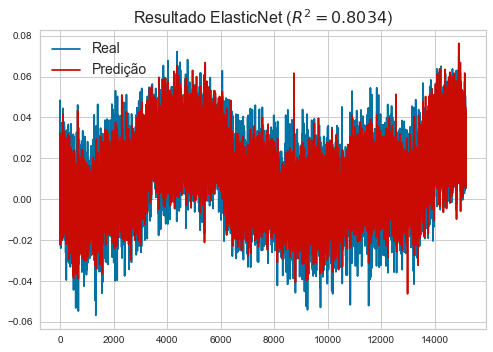

In [25]:
#Usando apenas ['CC_FL', 'CC_BL', 'AT_Y', 'AU_395_FR', 'AU_395_FL', 'AT_X', 'AT_Z']
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2=0.8034$)',size=16)
plt.legend(fontsize=14)

In [29]:
residuals = real - predito

## Suport Vector Machine (SVM)

In [70]:
from sklearn.svm import SVR

def objective(trial):
    
        
    sv_gamma = trial.suggest_float("gamma", low=0.0001, high=1, step=0.001)
    sv_C= trial.suggest_float("C", low=0.001, high=100,step=0.05)
    sv_epsilon= trial.suggest_float("epsilon", low=0.001, high=1,step=0.01)
    
    #sv_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    
    model = SVR(gamma=sv_gamma,C=sv_C,epsilon=sv_epsilon)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_svm = optuna.create_study(direction='maximize')

[I 2022-12-04 09:42:46,358] A new study created in memory with name: no-name-6d9d7fea-882b-4fb7-ad6a-fb6303b9fcab


In [8]:
#study_svm.optimize(objective, n_trials=20,show_progress_bar=True)

#trial = study_svm.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [9]:
#joblib.dump(study_svm, "study_SVM.pkl")

### AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=300, high=1000, step=25)
    h_learning_rate = trial.suggest_float("learning_rate", 0.1, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')

[I 2022-12-04 13:45:28,302] A new study created in memory with name: no-name-1ff24d54-a861-4994-ad98-627c8311e380


In [27]:
study_ab.optimize(objective, n_trials=25)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2022-12-04 13:46:43,917] Trial 0 finished with value: 0.6460208747342165 and parameters: {'n_estimators': 875, 'learning_rate': 0.3329324100546466, 'loss': 'linear'}. Best is trial 0 with value: 0.6460208747342165.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2022-12-04 13:47:10,571] Trial 1 finished with value: 0.6384456949416278 and parameters: {'n_estimators': 375, 'learning_rate': 0.8989828974520585, 'loss': 'linear'}. Best is trial 0 with value: 0.6460208747342165.
c:

Accuracy: 0.6631597327169456
Best hyperparameters: {'n_estimators': 975, 'learning_rate': 0.8329462460241329, 'loss': 'exponential'}


In [28]:
joblib.dump(study_ab, "study_AdaBost_B.pkl")

['study_AdaBost_B.pkl']

In [17]:
optuna.visualization.plot_optimization_history(study_ab)

In [204]:
optuna.visualization.plot_slice(study_ab)

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

In [29]:
import xgboost as xgb

def objective(trial):
    
        
    #x_max_depth = trial.suggest_int("max_depth",2,20)
    #x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    #x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    #x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    #x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    param = {
        'lambda': trial.suggest_loguniform('lambda',low=1e-3,high=5),
        'alpha': trial.suggest_loguniform('alpha', low=1e-3,high=5),
        'colsample_bytree': trial.suggest_float('colsample_bytree',low=0.3,high=1,step=0.1),
        'subsample': trial.suggest_float('subsample',0.1,1,step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000, 25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'random_state': 2020,
        'min_split_loss': trial.suggest_loguniform('min_split_loss',low=1e-3,high=0.1),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1,10,step=0.5),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3,1,step=0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1,step=0.1)
    }
    
    model = xgb.XGBRegressor(**param)  
    
    

   
    #model.fit(X_train_scaled,y_train)
    #p=model.predict(X_test_scaled)
    #score= r2_score(y_test,p)
    
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_xgbr= optuna.create_study(direction='maximize')

[I 2022-12-04 14:05:59,373] A new study created in memory with name: no-name-7706bb64-9f33-4a23-990c-05d5e500ca27


In [33]:
study_xgbr.optimize(objective, n_trials=20,show_progress_bar=True)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



: 

In [ ]:
joblib.dump(study_xgbr, "study_XGBoost_B.pkl")

['study_XGBoost.pkl']

In [31]:
optuna.visualization.plot_optimization_history(study_xgbr)

In [32]:
optuna.visualization.plot_slice(study_xgbr)

In [33]:
study = joblib.load("study_XGBoost.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ",study.best_params)

Best trial until now:
 Value:  0.7740430126296058
 Params:  {'lambda': 0.001530808845481313, 'alpha': 0.02111400159780091, 'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001, 'n_estimators': 5850, 'max_depth': 10, 'min_split_loss': 0.0027632330369892592, 'min_child_weight': 7.1, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 1.0}


In [35]:
import xgboost as xgb
mdl = xgb.XGBRegressor(**study.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



RMSE:  0.00010128150309338829
R2:  0.7740430126296058


In [38]:
predito_XGB = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)


In [217]:
residuals = real - predito

In [ ]:
sns.histplot(data=residuals,label='Resíduos')
plt.legend(fontsize=14)

In [ ]:
sns.boxplot(residuals)

Text(0.5, 1.0, 'Resultado XGBoost $R^2$ = 0.7740')

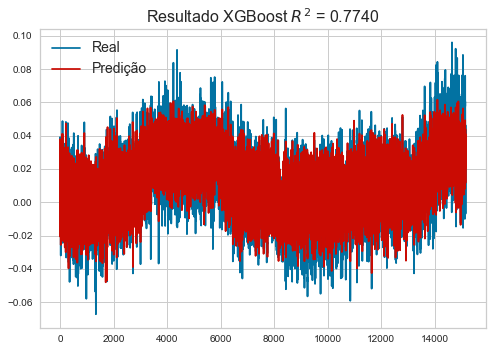

In [41]:
plt.plot(real,'b',label='Real')
plt.plot(predito_XGB,'r',label = 'Predição')
plt.legend(fontsize=14)
plt.title('Resultado XGBoost $R^2$ = 0.7740',size=16)
#plt.xlim([9000,10000])
#plt.ylim([-0.05,0.1])
#RMSE:  0.0001065447461351567
#R2:  0.7738208762340173

In [42]:
predicted_XGB = pd.DataFrame(p, columns = ['L/V_FR'])
predicted_XGB.to_csv(r'C:\Users\DELL\Desktop\PG\predito_xgboost.csv', index = False)
y_test.to_csv(r'C:\Users\DELL\Desktop\PG\teste_real.csv', index=False)

# Learning Curve

In [12]:
plt.figure(figsize=(12,6))

from yellowbrick.model_selection import LearningCurve

# Load a regression dataset

# Instantiate the regression model and visualizer
#model = ElasticNet(**study_en.best_params,random_state=2020)
#visualizer = LearningCurve(model, scoring='r2')

#visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
#visualizer.show()           # Finalize and render the figure

<Figure size 864x432 with 0 Axes>

# Real intrumantation IRV

In [6]:
X_IRV, y_IRV = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_FR']]
X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV = create_scaled_dataset(X_IRV,y_IRV)

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), ElasticNet(alpha=0.001, l1_ratio=0.2)]

Obtaining R2 score for all 6 models


 17%|█▋        | 1/6 [00:00<00:01,  3.76it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_6920\2041063366.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 33%|███▎      | 2/6 [00:21<00:51, 12.83s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 50%|█████     | 3/6 [00:29<00:30, 10.27s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 4/6 [00:49<00:28, 14.34s/it]C

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


Obtaining feature importance - 100%
CPU times: total: 2min 3s
Wall time: 59.9 s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

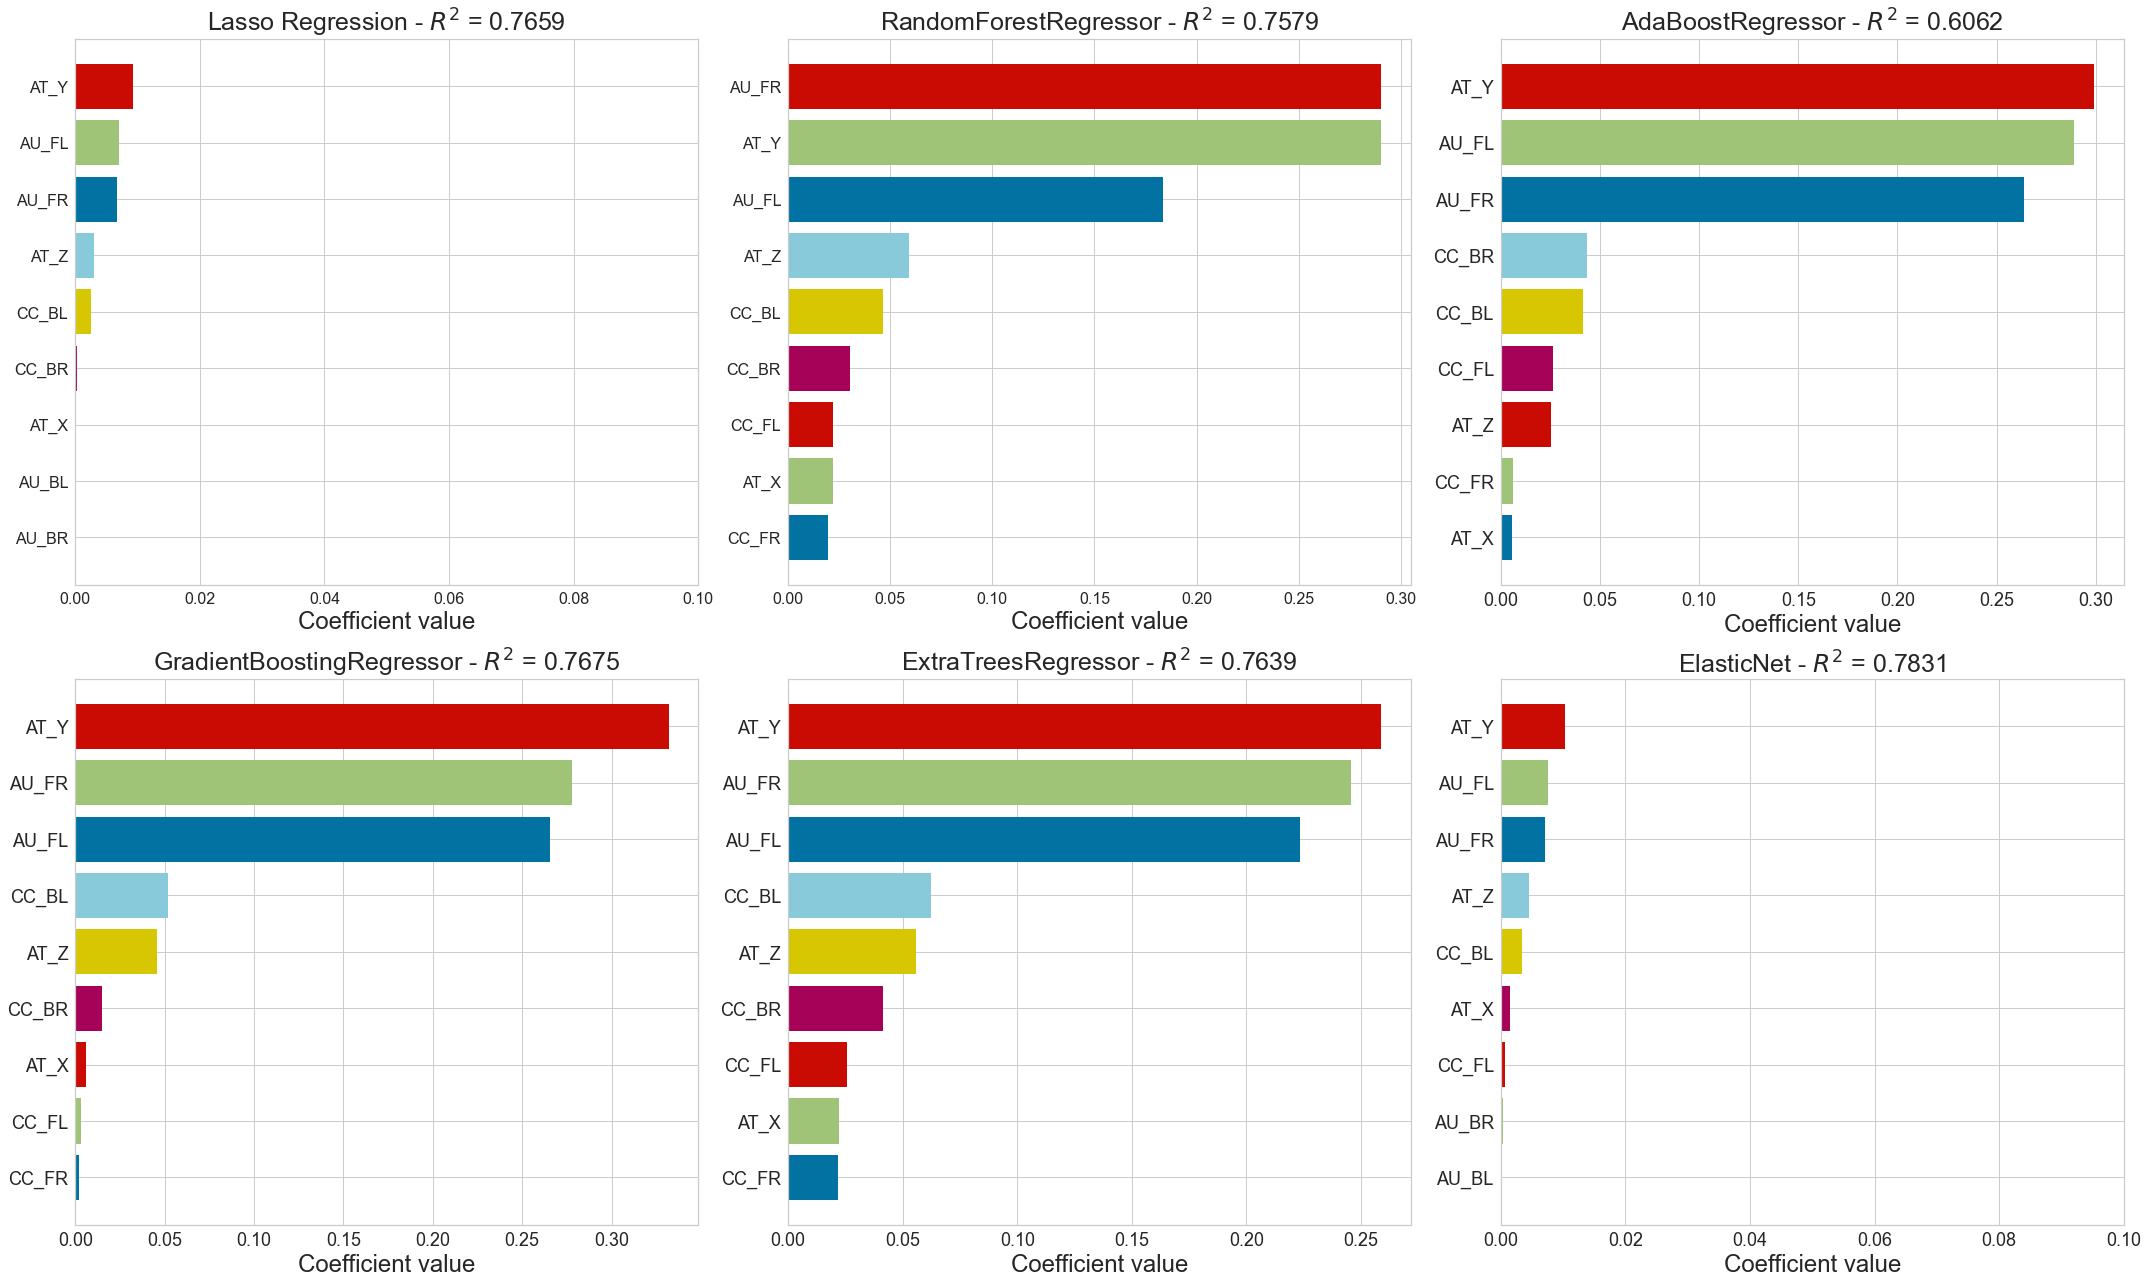

In [7]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

In [44]:
X_IRV, y_IRV2 = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_BR']]
X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2 = create_scaled_dataset(X_IRV,y_IRV2)

In [48]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=11):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=11, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=32, max_features=6, min_samples_leaf=6,
                      min_samples_split=4, n_estimators=330, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 33%|███▎      | 2/6 [01:25<02:51, 42.94s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

 50%|█████     | 3/6 [09:30<11:20, 226.97s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [09:51<05:00, 150.22s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



Obtaining feature importance - 100%
CPU times: total: 30min 19s
Wall time: 10min 1s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

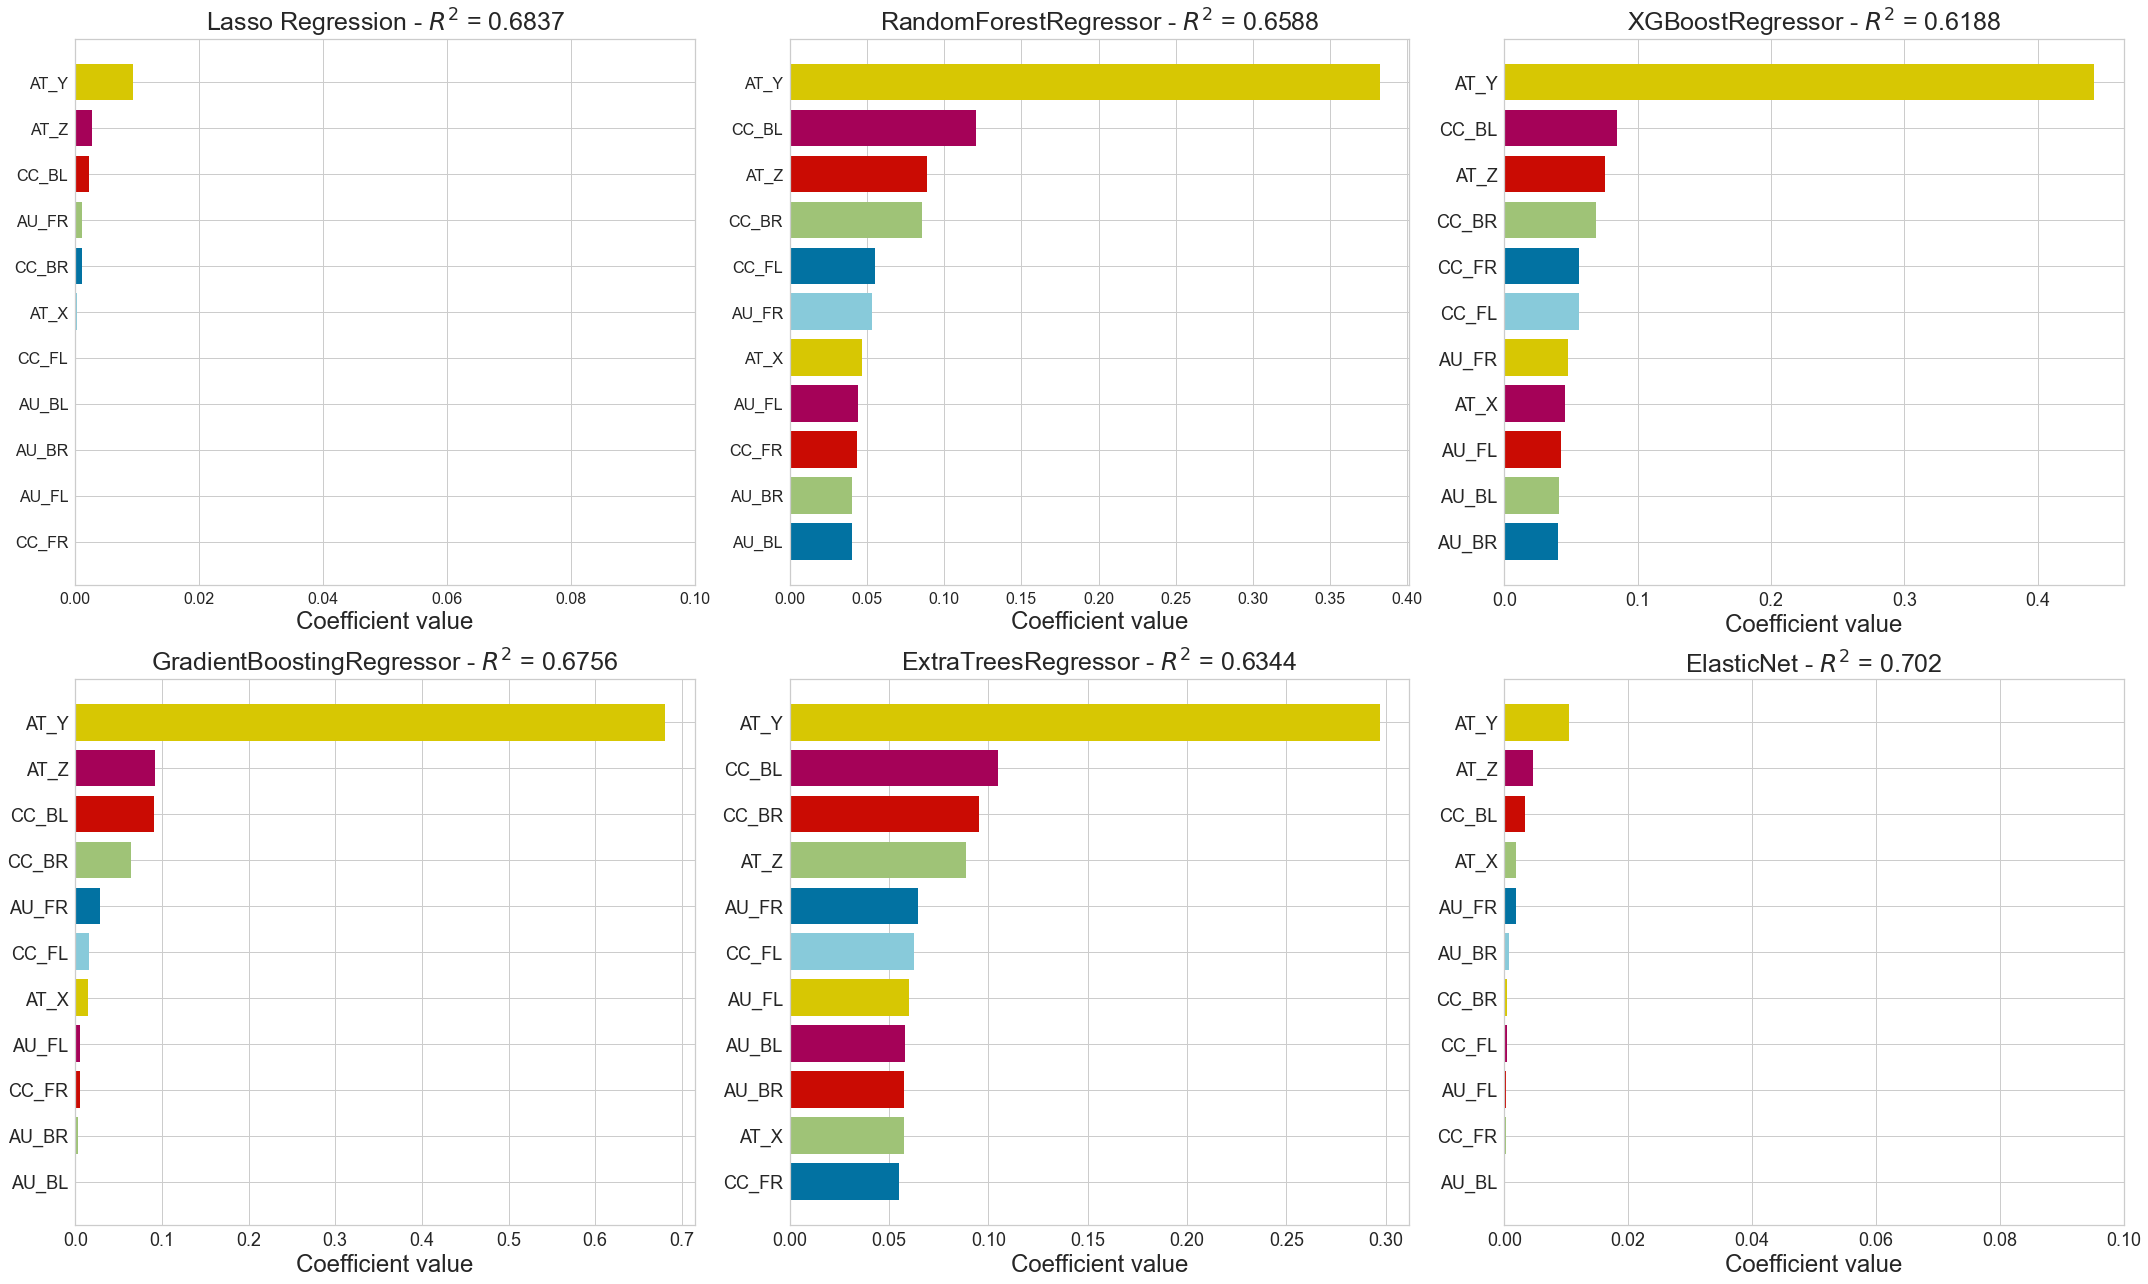

In [49]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=32, max_features=6, min_samples_leaf=6,
                      min_samples_split=4, n_estimators=330, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 33%|███▎      | 2/6 [01:25<02:51, 42.94s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

 50%|█████     | 3/6 [09:30<11:20, 226.97s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [09:51<05:00, 150.22s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



Obtaining feature importance - 100%
CPU times: total: 30min 19s
Wall time: 10min 1s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

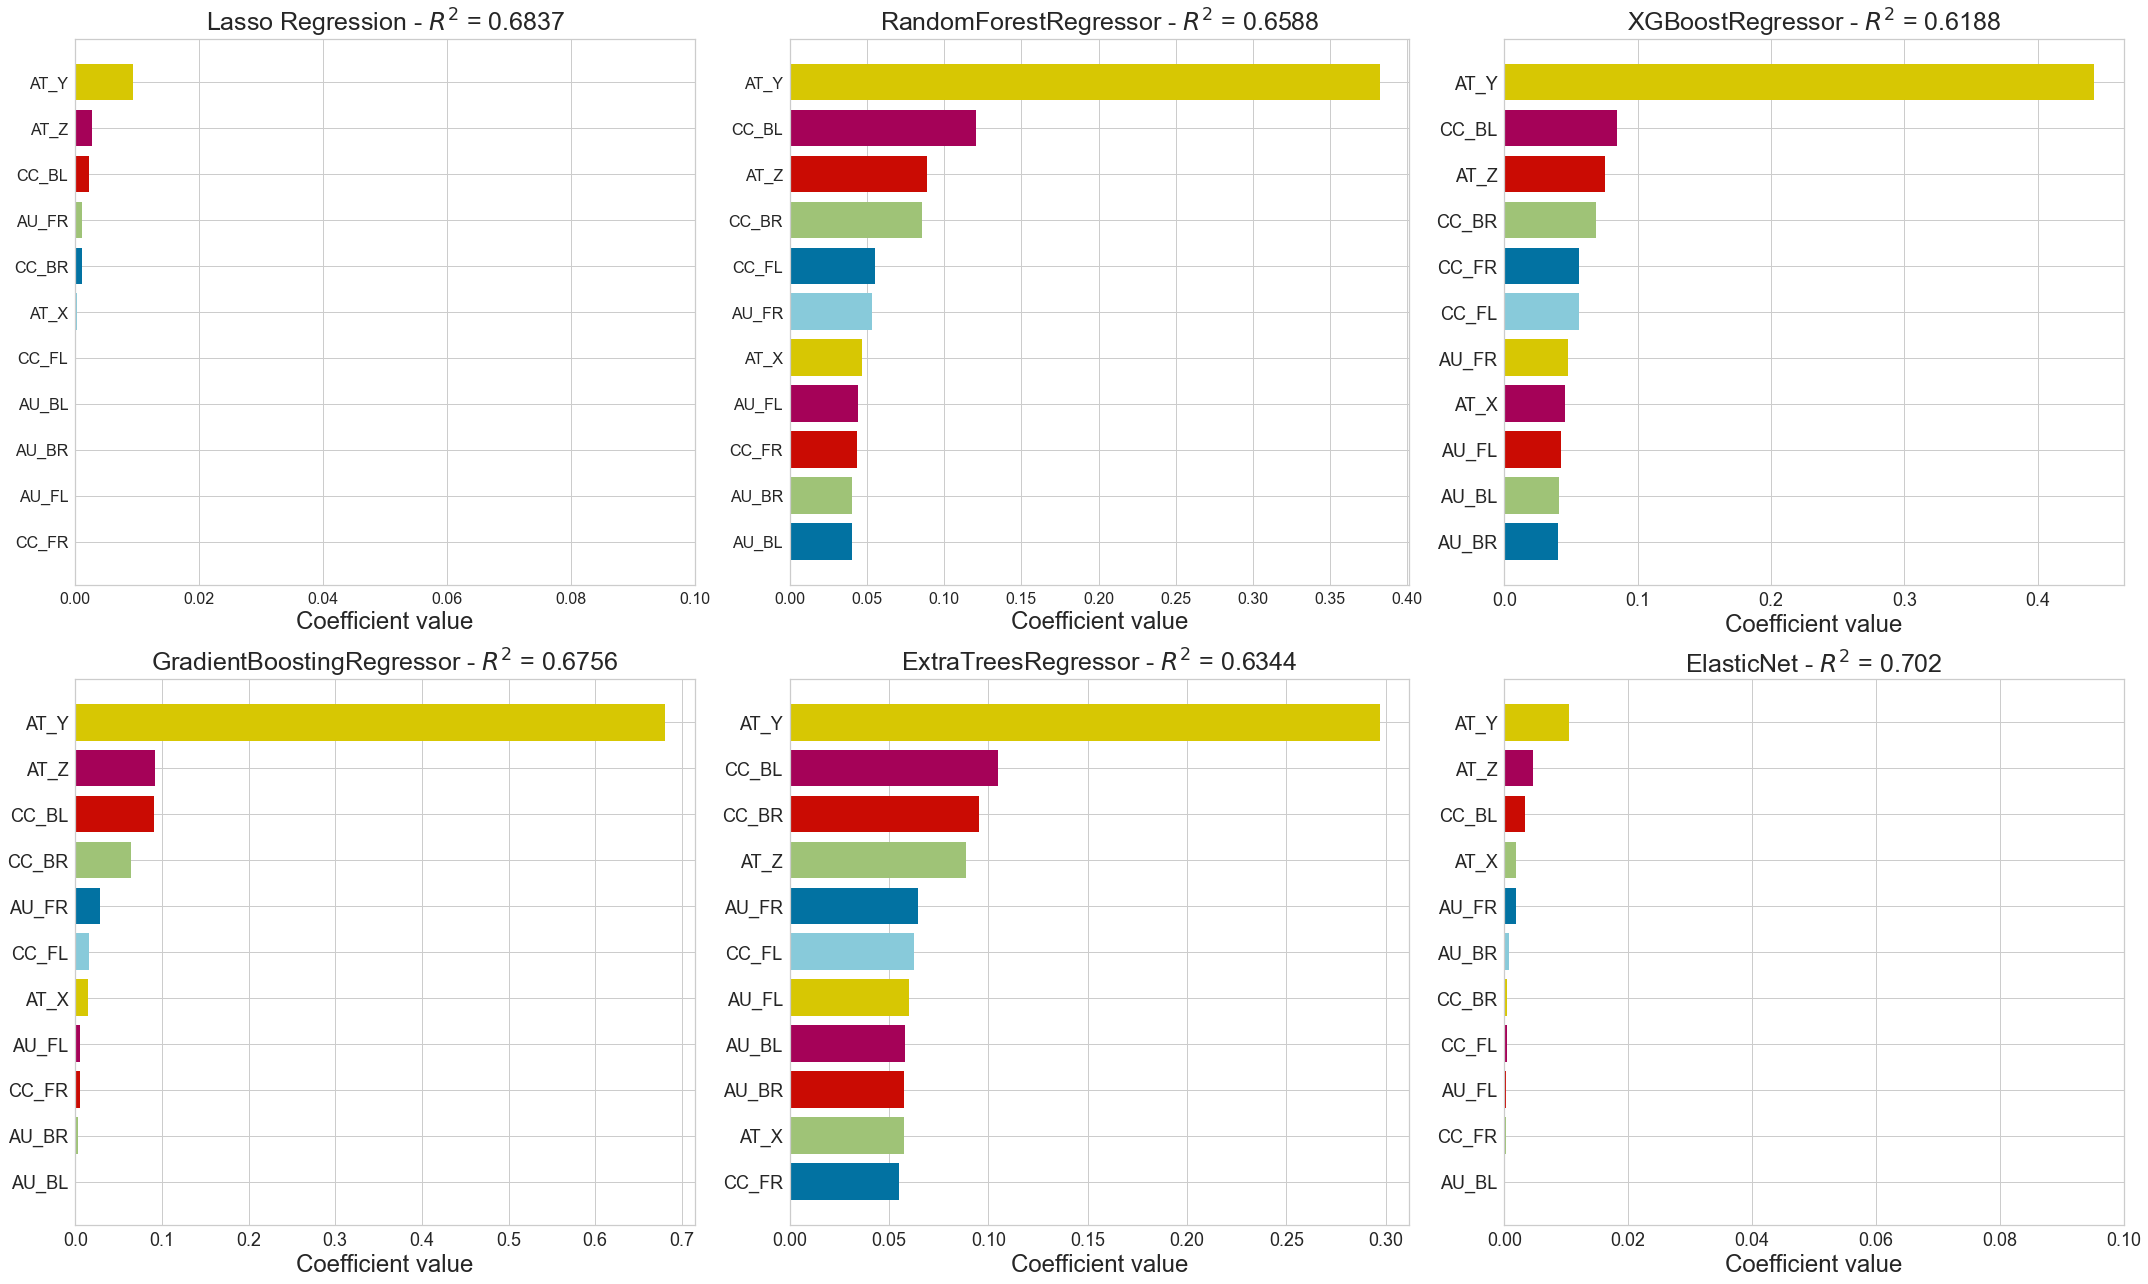

In [ ]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')